### 数据处理

#### 对于每个物种，确保每个基因ID只对应一条数据 
规则：如果一个基因ID对应多条则取最长的，如果长度都相同则取第一个。

In [5]:
from Bio import SeqIO
from tqdm import tqdm
import os

# 寻找文件
def find_faa_files(directory,pattern):
  for root, dirs, files in os.walk(directory):
    for file in files:
      if file.endswith(pattern):
        yield os.path.join(root, file)

# 获取faa文件的基因ID
def extract_gene_id(record_description):
    for part in record_description.split():
        if part.startswith("[GeneID="):
            return part.split("=")[-1].rstrip("]")

# 读取faa文件并存入字典
def parse_faa(faa_file):
    gene_id_to_records = {}
    for record in SeqIO.parse(faa_file, "fasta"):
        gene_id = extract_gene_id(record.description)
        if gene_id not in gene_id_to_records:
            gene_id_to_records[gene_id] = [record]
        else:
            gene_id_to_records[gene_id].append(record)
    return gene_id_to_records

# 获取faa文件中的基因id以及对应序列最大长度的索引
def get_faa_length_index(faa_dict):
    faa_length_dict = {}
    for element, record in faa_dict.items():
            length = [len(seq_list) for seq_list in faa_dict[element]]
            faa_length_dict[element] = length.index(max(length))
    return faa_length_dict

# 按照索引重新写入faa文件
def re_write(faa_dict,faa_length_dict,output_faa_path):
    with open(output_faa_path, "w") as file:
        for gene_id,records in faa_dict.items():
            record = faa_dict[gene_id][faa_length_dict[gene_id]]
            SeqIO.write(record, file, "fasta")


if __name__ == "__main__":
    input_faa_path = '/home/qiansongping/Experimental_Fish_3/1.Datasets/fish_faa_gff_sort'  #faa文件数据路径
    output_file = '/home/qiansongping/Experimental_Fish_3/1.Datasets/dataset' #输出文件主路径
    files_faa = find_faa_files(input_faa_path,'.faa') #获取faa文件列表
    for faa_file in tqdm(files_faa):  #遍历文件
        species_number = faa_file.split('/')[-1].split('_')[0] #获取物种编号
        output_faa_path = output_file + '/' + species_number + '_protein.faa'
        faa_dict = parse_faa(faa_file) #读取faa文件并存入字典
        faa_length_index = get_faa_length_index(faa_dict) #获取faa文件和索引
        re_write(faa_dict,faa_length_index,output_faa_path) #重写faa文件
    print('完成')


153it [02:16,  1.12it/s]

完成


In [3]:
'''
筛选实验物种
'''
import os
import shutil

path = '/home/qiansongping/Experimental_Fish_3/1.Datasets/dataset'
sea = [215358, 129043, 441366, 181472, 173247, 41447, 2871759, 109905, 80966, 80972, 144197, 7950, 184585, 8049, 80720, 1042646, 586833, 8245, 375764, 241271, 56723, 1203425, 508554, 433405, 229290, 184440, 56716, 8103, 293821, 300413, 310571, 8218, 160734, 52239, 2059687, 72105, 40690, 8267, 195615, 8255, 8262, 52904, 28829, 90069, 27771, 13676, 8236, 8240, 13677, 8175, 161448, 161450, 161453, 109280, 109293, 270530, 161584, 693459, 161469, 161592, 161455, 433684]
fresh = [64144, 158456, 1250792, 390379, 8090, 30732, 147949, 119488, 7994, 42526, 42514, 63155, 8154, 8153, 106582, 32507, 303518, 43689, 299321, 7959, 7955, 1142201, 84645, 369639, 90988, 1606681, 992332, 1582913, 52670, 77115, 33528, 208333, 37003, 105023, 8081, 48698, 48701, 188132, 8083, 8084, 32473, 8010, 409849, 8005, 137520, 42636, 1676925, 113540, 210632, 54343, 417921, 8167, 8168, 283035, 941984, 13013, 337641, 7998, 66913, 310915, 175797, 1234273, 175792, 2290929, 205130, 43700]
ids = fresh + sea

for file in os.listdir(path):
    fid = file.split('_')[0]
    if int(fid) not in ids:
        os.remove(path + '/' + file)


#### 统计出每个物种的基因数目

In [8]:
import os
from Bio import SeqIO

def find_faa_files(directory,pattern):
  for root, dirs, files in os.walk(directory):
    for file in files:
      if file.endswith(pattern):
        yield os.path.join(root, file)

specie = {}
output_file = '/home/qiansongping/Experimental_Fish_3/1.Datasets/dataset' #输出文件主路径
count = []
for file in os.listdir(output_file):
    count.append(len(list(SeqIO.parse(os.path.join(output_file,file), 'fasta'))))
    specie[file.split('_')[0]] = len(list(SeqIO.parse(os.path.join(output_file,file), 'fasta')))


In [17]:
sum(count) / 153

23465.895424836603

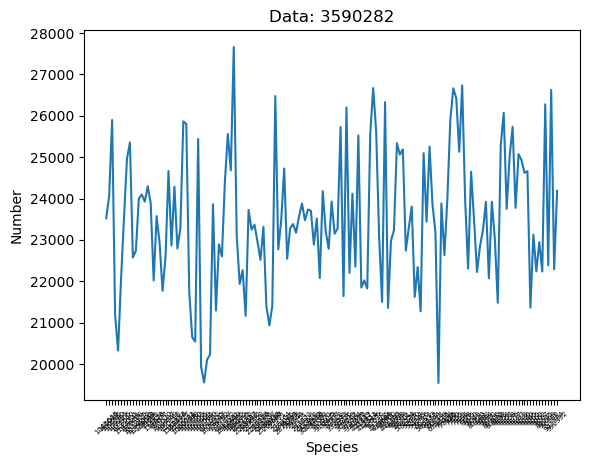

In [20]:
import matplotlib.pyplot as plt

plt.Figure(figsize=(60,40))
xticks = list(specie.keys())
plt.plot(specie.keys(),specie.values())
plt.xticks(xticks,rotation=45,fontsize=5)

# 添加标题和标签
plt.title(f'Data: {sum(count)}')
plt.xlabel('Species')
plt.ylabel('Number')

plt.show()

#### Orthofinder处理

In [1]:
'''
Orthofinder结果处理与重新写入
'''
from Bio import SeqIO
import os
import csv
from tqdm import tqdm
import json

# 输入文件路径
fish_path = '/home/qiansongping/Experimental_Fish_3/1.Datasets/dataset' #去重后的faa文件数据路径
# 输出文件
output_path = '/home/qiansongping/Experimental_Fish_3/2.Orthofinder/Data_og'

tsv_path = "/home/qiansongping/Experimental_Fish_3/2.Orthofinder/Orthogroups.tsv" # 180个物种

group_empty = {} #存储每个group中没有genebank的物种
orthogroup = {}   #存储每个group的genebank
with open(tsv_path,'r', newline='', encoding='utf-8') as file:
    reader = csv.reader(file,delimiter='\t')
    species = next(reader)  #去除列名
    for line in reader:
        group = line[0] #获取聚类号
        genebank = line[1:] #获取基因bank号
        group_empty[group] = sum(1 for item in genebank if item.strip() == '')
        orthogroup[group] = genebank

# 按照升序进行排序并取出数据
sorted_count = dict(sorted(group_empty.items(), key=lambda item: item[1]))
count_list = {}
group_dict = {}
for group,count in sorted_count.items():
    if (count/153) <= 0.10:
        count_list[group] = orthogroup[group]
        gene_bank = [item.strip() for items in orthogroup[group] for item in items.split(',') if item.strip()] #把所有符合条件的genebank号按照group号顺序合在一个字典中
        for gene in gene_bank: #遍历基因
            group_dict[gene] = group

for file in tqdm(os.listdir(fish_path)):
    output_file = os.path.join(output_path, file.split('_')[0]+'_group.faa')
    GeneBank_seq = {}
    #将每个物种的序列提取出来，一个genebank对应一条序列
    for record in SeqIO.parse(fish_path+'/'+file, 'fasta'):
        GeneBank_seq[record.id] = record    
    
    # 根据group号写入文件
    with open(output_file, 'w') as f:
        for Genebank,group in group_dict.items():
            if Genebank in GeneBank_seq:
                record = GeneBank_seq[Genebank]
                reco = SeqIO.SeqRecord(record.seq, id=f"{record.id}", description=f"{record.description} GP={group_dict[Genebank]}")
                SeqIO.write(reco, f, "fasta")

In [2]:
import csv
tsv_path = "/home/qiansongping/Experimental_Fish_3/2.Orthofinder/Orthogroup_128.tsv" # 180个物种

group_empty = {} #存储每个group中没有genebank的物种
orthogroup = {}   #存储每个group的genebank
with open(tsv_path,'r', newline='', encoding='utf-8') as file:
    reader = csv.reader(file,delimiter='\t')
    species = next(reader)  #去除列名
    for line in reader:
        group = line[0] #获取聚类号
        genebank = line[1:] #获取基因bank号
        group_empty[group] = sum(1 for item in genebank if item.strip() == '')
        orthogroup[group] = genebank

In [ ]:
count_list = {}
sorted_count = dict(sorted(group_empty.items(), key=lambda item: item[1]))
for group,count in sorted_count.items():
    if (count/153) <= 0.10:
        print(group,count)
        count_list[group] = orthogroup[group]
 

In [4]:
len(count_list)

14440

In [5]:
'''
实验数据统计与可视化
'''
from Bio import SeqIO
from tqdm import tqdm
import os
import json

count = {}
for file in tqdm(os.listdir('/home/qiansongping/Experimental_Fish_3/2.Orthofinder/Data_og')):
    output_file = os.path.join('/home/qiansongping/Experimental_Fish_3/2.Orthofinder/Data_og',file)
    records = SeqIO.parse(output_file, 'fasta')
    count[output_file.split('/')[-1]] =  len(list(records))  

with open('/home/qiansongping/Experimental_Fish_3/2.Orthofinder/count.json','w',encoding='utf-8') as f:
    json.dump(count,f,indent=4)

100%|██████████| 153/153 [00:32<00:00,  4.68it/s]


In [12]:
'''
实验数据统计与可视化
'''
from Bio import SeqIO
from tqdm import tqdm
import os
import json

count = {}
for file in tqdm(os.listdir('/home/qiansongping/Experimental_Fish_3/1.Datasets/fish_faa_gff_sort')):
    output_file = os.path.join('/home/qiansongping/Experimental_Fish_3/1.Datasets/fish_faa_gff_sort',file)
    records = SeqIO.parse(output_file, 'fasta')
    count[output_file.split('/')[-1]] =  len(list(records))  

with open('/home/qiansongping/Experimental_Fish_3/2.Orthofinder/count_GFF.json','w',encoding='utf-8') as f:
    json.dump(count,f,indent=4)

100%|██████████| 153/153 [01:24<00:00,  1.81it/s]


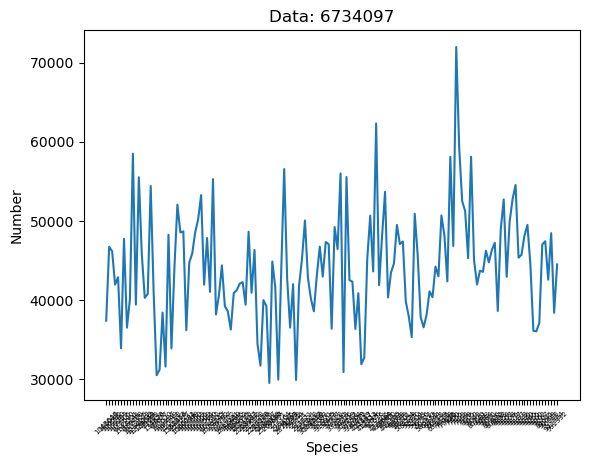

In [13]:
import matplotlib.pyplot as plt

plt.Figure(figsize=(60,40))
xticks = [k.split('_')[0] for k in count.keys()]
plt.plot(xticks,count.values())
plt.xticks(xticks,rotation=45,fontsize=5)

# 添加标题和标签
plt.title(f'Data: {sum(count.values())}')
plt.xlabel('Species')
plt.ylabel('Number')

plt.show()

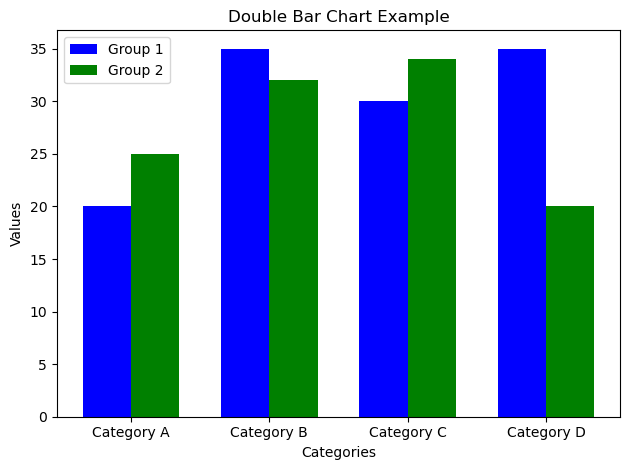

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# 数据准备
categories = ['Category A', 'Category B', 'Category C', 'Category D']
group1 = [20, 35, 30, 35]
group2 = [25, 32, 34, 20]

# 设置柱子宽度和位置
bar_width = 0.35
index = np.arange(len(categories))

# 创建柱状图
fig, ax = plt.subplots()
bar1 = ax.bar(index, group1, bar_width, label='Group 1', color='b')
bar2 = ax.bar(index + bar_width, group2, bar_width, label='Group 2', color='g')

# 添加标签、标题等
ax.set_xlabel('Categories')
ax.set_ylabel('Values')
ax.set_title('Double Bar Chart Example')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(categories)
ax.legend()

# 显示图表
plt.tight_layout()
plt.show()



#### Blast序列比对

In [3]:
'''
blast数据库构建,利用有基因名的序列
'''
from Bio import SeqIO
import os
import json
import pandas as pd
from tqdm import tqdm

protein_path = '/home/qiansongping/Experimental_Fish_3/2.Orthofinder/Data_og' #去重后的faa文件数据路径
# 输出文件
output_file = '/home/qiansongping/Experimental_Fish_3/3.Blast/protein_seq/fish_protein.faa' #输出文件路径

# 遍历输入文件目录
with open(output_file, 'w') as f:
    for file in tqdm(os.listdir(protein_path)):
        # 读取输入文件
        records = SeqIO.parse(os.path.join(protein_path, file), 'fasta')
        for record in records:
            if not record.description.split()[1].startswith('LOC'):
                    SeqIO.write(record, f, 'fasta')


100%|██████████| 153/153 [00:36<00:00,  4.24it/s]


In [4]:
'''
提取LOC基因名序列作为比对数据
'''
from Bio import SeqIO
import os
import json
import pandas as pd
from tqdm import tqdm

protein_path = '/home/qiansongping/Experimental_Fish_3/2.Orthofinder/Data_og' #去重后的faa文件数据路径
# 输出文件
output_file = '/home/qiansongping/Experimental_Fish_3/3.Blast/protein' #输出文件路径

# 遍历输入文件目录
for file in tqdm(os.listdir(protein_path)):
    # 读取输入文件
    records = SeqIO.parse(os.path.join(protein_path, file), 'fasta')
    with open(output_file+'/'+file.split('_')[0]+'_LOC.faa', 'w') as f:
        for record in records:
            if record.description.split()[1].startswith('LOC'):
                    SeqIO.write(record, f, 'fasta')

100%|██████████| 153/153 [00:24<00:00,  6.14it/s]


In [ ]:
'''
blast比对
'''
import os
import subprocess
import warnings
import multiprocessing

warnings.filterwarnings("ignore")

def run_blast(faa_file, output_file, db_path):
    command = f'blastp -query {faa_file} -db {db_path} -out {output_file} -evalue 1e-5 -max_target_seqs 1 -max_hsps 1 -num_threads 30 -outfmt 6'
    try:
        # 使用subprocess.Popen执行命令
        process = subprocess.Popen(command, shell=True)
        # 等待命令执行完成
        process.wait()
        # 终止已完成的进程
        process.terminate()
        print(f'------------------------------------------------Blast completed---------------------------------------------------------')
    except subprocess.CalledProcessError as e:
        print(f"Error occurred while running blast: {str(e)}")

if __name__ == '__main__':
    files = '/home/qiansongping/Experimental_Fish_3/3.Blast/protein'  # 输入文件主路径
    db_path = '/home/qiansongping/Experimental_Fish_3/3.Blast/blast_database/fish_blast'  # 数据库路径
    output_path = '/home/qiansongping/Experimental_Fish_3/3.Blast/result'  # 输出文件路径
    input_path = os.listdir(files)  # 获取输入文件列表

    pool = multiprocessing.Pool(processes=5)  # 创建进程池

    for file in input_path:  # 遍历输入文件列表
        faa_file = os.path.join(files, file)  # 获取输入文件路径
        output_file = os.path.join(output_path, file.split('_')[0] + '_blast.txt')  # 获取输出文件路径
        pool.apply_async(run_blast, args=(faa_file, output_file, db_path))  # 异步提交任务到进程池

    pool.close()  # 关闭进程池，不再接受新任务
    pool.join()  # 等待所有任务完成

#### BPE

In [1]:
'''
BPE数据准备--text文件
'''
import os
from Bio import SeqIO
from tqdm import tqdm

def find_faa_files(directory,pattern):
  for root, dirs, files in os.walk(directory):
    for file in files:
      if file.endswith(pattern):
        yield os.path.join(root, file)

input_file = '/home/qiansongping/Experimental_Fish_3/2.Orthofinder/Data_og' #输入文件主路径
output_file = '/home/qiansongping/Experimental_Fish_3/4.BPE/data_txt'
files = find_faa_files(input_file, '.faa')

for file in tqdm(files):
    species_number = file.split('/')[-1].split('_')[0]
    output_file_path = os.path.join(output_file, species_number+'_group.txt')

    records = SeqIO.parse(file, 'fasta')
    with open(output_file_path, 'w',encoding='utf-8') as f:
        for record in records:
            seq = str(record.seq)
            f.write(seq + '\n')
        f.close()
print('完成')  

153it [00:21,  7.27it/s]

完成


In [ ]:
''' 
BPE分词器训练
'''
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, decoders, processors
import os
import csv
from tqdm import tqdm

def find_files(file_path, pattern):
    """
    查找文件
    """
    # 使用os.walk遍历目录，获取所有子目录
    for root, dirs, files in os.walk(file_path):
        # 计算当前目录下匹配到的文件数量
        for file in files:
            if file.endswith(pattern):
                yield os.path.join(root, file)

def protein_sequences_generator(file_paths):
    """
    读取数据
    """
    file_paths = list(file_paths)
    print(f"找到{len(file_paths)}个文件")
    for file_path in tqdm(file_paths,desc='正在读取文件:'):
        with open(file_path, 'r') as file:
            for sentence in file:
                yield sentence.strip()

def train_bpe_tokenizer(corpus, bpe_save_path, vocab_size, min_frequency):
    """
    使用BPE算法训练分词器
    """
    all_seq = list(corpus)
    print("总长度:",len(all_seq))
    # 初始化分词器
    tokenizer = Tokenizer(models.BPE())

    # 添加预处理器、解码器和处理器
    tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()
    tokenizer.decoder = decoders.ByteLevel()
    tokenizer.post_processor = processors.ByteLevel(add_prefix_space=True) #是否添加标识符，如开始和结束

    # 训练BPE模型
    trainer = trainers.BpeTrainer(special_tokens=["[PAD]", "[CLS]", "[SEP]", "[MASK]", "[UNK]"],vocab_size=vocab_size, min_frequency=min_frequency)
    print("开始训练BPE模型...")
    tokenizer.train_from_iterator(all_seq, trainer=trainer)
    # 保存分词器
    print("保存分词器...")
    tokenizer.save(bpe_save_path)
    return tokenizer

if __name__ == "__main__":
    #所有蛋白质序列文件路径以及BPE分词后的输出文件路径
    bpe_save_path = "/home/qiansongping/Experimental_Fish_3/4.BPE/bpe_results/bpe_tokenizer.json"
    input_path = '/home/qiansongping/Experimental_Fish_3/4.BPE/data_txt'
    print('正在查找文件')
    file_paths = find_files(input_path, '.txt')
    print('读取蛋白质数据')
    protein_sequences = protein_sequences_generator(file_paths)
    '''
        训练BPE分词器
        k-mer:保留80%的词有9100多个，保留75%的词有8553多个
    '''
    tokenizer = train_bpe_tokenizer(protein_sequences, bpe_save_path, vocab_size=9000, min_frequency=300) 
    print('训练BPE分词完成')

In [14]:
'''
物种BPE分词
'''
from Bio import SeqIO
import os
import csv
from tqdm import tqdm
from tokenizers import Tokenizer

def find_faa_files(directory,pattern):
  for root, dirs, files in os.walk(directory):
    for file in files:
      if file.endswith(pattern):
        yield os.path.join(root, file)

def tokenize_protein_sequence(sequence, tokenizer):
    """
    使用训练好的分词器对蛋白质序列进行分词
    """
    # 对蛋白质序列进行分词
    encoding = tokenizer.encode(sequence)
    
    # 获取分词后的标记
    tokens = encoding.tokens

    return tokens

if __name__ == "__main__":
    input_path = '/home/qiansongping/Experimental_Fish_3/2.Orthofinder/Data_og'
    output_path = '/home/qiansongping/Experimental_Fish_3/4.BPE/protein_data'

    bpe_path = "/home/qiansongping/Experimental_Fish_3/4.BPE/bpe_results/bpe_tokenizer.json"

    faa_files = find_faa_files(input_path, '.faa')
    tokenizer = Tokenizer.from_file(bpe_path)

    for faa_file in tqdm(faa_files,desc='正在处理'):
        protein_number = faa_file.split('/')[-1].split('_')[0]

        output_file = os.path.join(output_path,protein_number+'_token_bpe.csv')
        with open(output_file,'w',newline='',encoding='utf-8') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['GenBank','Group','Sequence'])
            for record in SeqIO.parse(faa_file,'fasta'):
                  group = [i.split("=")[1] for i in record.description.split() if i.startswith("GP")]
                  sequence = tokenize_protein_sequence(str(record.seq),tokenizer)
                  writer.writerow([record.id,group[0],' '.join(sequence)])   
            csvfile.close()
    print('BPE分词完成！')

正在处理: 153it [18:33,  7.28s/it]

BPE分词完成！


#### Word2vec词嵌入

In [3]:
from collections import Counter
import json
import os
from tqdm import tqdm

def count_words_in_files(filenames):
    counter = Counter()
    for filename in tqdm(filenames):
          with open(filename, 'r', encoding='utf-8') as csv_file:
                 csv_reader = csv.reader(csv_file, delimiter=',')
                 next(csv_reader) #过滤第一行列名
                 for row in csv_reader:
                    seq = row[2].replace("Ġ", "").split()
                    counter.update(seq)
    return counter

def find_files(directory,pattern):
  for root, dirs, files in os.walk(directory):
    for file in files:
      if file.endswith(pattern):
        yield os.path.join(root, file)

if __name__ == '__main__':
    filenames = find_files('/home/qiansongping/Experimental_Fish_3/4.BPE/protein_data', '.csv')
    output_path = '/home/qiansongping/Experimental_Fish_3/4.BPE/bpe_results/words_count.json'
    counter = count_words_in_files(filenames)
    with open(output_path, 'w') as f:
          json.dump(counter, f)
    print('Done')

153it [02:32,  1.00it/s]

Done


In [1]:
import json
import numpy as np

input_path = '/home/qiansongping/Experimental_Fish_3/4.BPE/bpe_results/words_count.json'
with open(input_path, "r") as f:
    word_counts = json.load(f)

counts = []
sorted_word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))
print(f'总词数：{len(sorted_word_counts)}')
'''二八定律，幂律分布'''
min_count =  np.percentile(list(sorted_word_counts.values()), 10) #保留90%的词频
print("10% percentile:", min_count)
filtered_words = {word: count for word, count in sorted_word_counts.items() if count > min_count}
print(len(filtered_words))

总词数：8949
10% percentile: 9137.8
8054


In [2]:
len(word_counts)

8949

In [17]:
sum(word_counts.values())

754961137

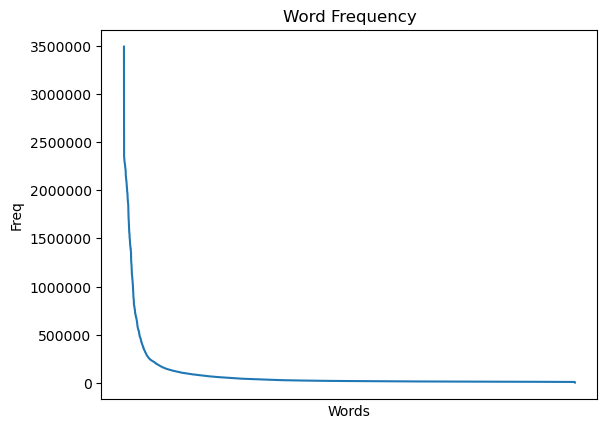

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# 假设这是你已经生成的图形
plt.plot(sorted_word_counts.keys(), sorted_word_counts.values())

# 设置y轴为常规数字显示而不是科学计数法
plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=False))
plt.gca().yaxis.get_major_formatter().set_scientific(False)
plt.gca().yaxis.get_major_formatter().set_useOffset(False)

# 设置标题和标签
plt.title("Word Frequency")
plt.xlabel("Words")
plt.ylabel("Freq")
plt.xticks([])

# 显示图形
plt.show()


In [ ]:
import os
from gensim.models import Word2Vec
import logging
import csv

class readcsv:
    def __init__(self,file_path,pattern):
        self.file_path = file_path
        self.pattern = pattern

    def find_files(self):
        # 使用os.walk遍历目录，获取所有子目录
        for root, dirs, files in os.walk(self.file_path):
            # 计算当前目录下匹配到的文件数量
            for file in files:
                if file.endswith(self.pattern):
                    yield os.path.join(root, file)
    
    def __iter__(self):
        for file in self.find_files():
            with open(file, 'r', encoding='utf-8') as csv_file:
                 csv_reader = csv.reader(csv_file, delimiter=',')
                 next(csv_reader) #过滤第一行列名
                 for row in csv_reader:
                    seq = row[2].replace("Ġ", "")
                    yield seq.strip().split()
                
corpus_path = '/home/qiansongping/Experimental_Fish_3/4.BPE/protein_data'

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

sentences = readcsv(corpus_path, '.csv')
'''sg = 0: CBOW（连续词袋模型）
   sg=1 : skip-gram（跳字模型）
   window: 窗口大小，即考虑当前词和其前后多少个词
   min_count: 词频阈值，低于此阈值的词会被忽略
   workers: 并行训练的线程数
'''
model = Word2Vec(sentences, vector_size=100, window=20, min_count=300, workers=32, sg=0)
model.init_sims(True)
model.save("/home/qiansongping/Experimental_Fish_3/4.BPE/bpe_results/word2vec_model_cbow.model")
print('训练完成！')

### 数据扩充

#### 淡水鱼和海水鱼数据提取

In [4]:
import os
import shutil
from tqdm import tqdm

In [5]:
sea = [215358, 129043, 441366, 181472, 173247, 41447, 2871759, 109905, 80966, 80972, 144197, 7950, 184585, 8049, 80720, 1042646, 586833, 8245, 375764, 241271, 56723, 1203425, 508554, 433405, 229290, 184440, 56716, 8103, 293821, 300413, 310571, 8218, 160734, 52239, 2059687, 72105, 40690, 8267, 195615, 8255, 8262, 52904, 28829, 90069, 27771, 13676, 8236, 8240, 13677, 8175, 161448, 161450, 161453, 109280, 109293, 270530, 161584, 693459, 161469, 161592, 161455, 433684]
fresh = [64144, 158456, 1250792, 390379, 8090, 30732, 147949, 119488, 7994, 42526, 42514, 63155, 8154, 8153, 106582, 32507, 303518, 43689, 299321, 7959, 7955, 1142201, 84645, 369639, 90988, 1606681, 992332, 1582913, 52670, 77115, 33528, 208333, 37003, 105023, 8081, 48698, 48701, 188132, 8083, 8084, 32473, 8010, 409849, 8005, 137520, 42636, 1676925, 113540, 210632, 54343, 417921, 8167, 8168, 283035, 941984, 13013, 337641, 7998, 66913, 310915, 175797, 1234273, 175792, 2290929, 205130, 43700]

ids_str = fresh + sea

input_path = '/home/qiansongping/Experimental_Fish_3/4.BPE/protein_data'
a = []
files = os.listdir(input_path)
output_path = '/home/qiansongping/Experimental_Fish_3/5.Data_padding/Data'
for file in tqdm(files):
    k = file.split('_')[0].strip()
    if int(k) in ids_str:
        shutil.copy(os.path.join(input_path,file),output_path)
print(f'{len(ids_str)}个鱼类数据已复制到指定文件夹')

100%|██████████| 153/153 [00:01<00:00, 124.06it/s]

128个鱼类数据已复制到指定文件夹


#### 数据采样

In [1]:
import pandas as pd
import random
import os 
from tqdm import tqdm
import csv
import numpy as np

def process_sample_csv(tsv_file,input_path, output_path, sample_size, num_samples, sample_num):   
    '''
    sample_size:每个样本采样多少个group
    num_samples:采样次数
    sample_num:原始样本数
    '''
    group_empty = {} #存储每个group中没有genebank的物种
    orthogroup = {}   #存储每个group的genebank
    with open(tsv_file,'r', newline='', encoding='utf-8') as file:
        reader = csv.reader(file,delimiter='\t')
        species = next(reader)  #去除列名
        for line in reader:
            group = line[0] #获取聚类号
            group_empty[group] = sum(1 for item in line[1:] if item.strip() == '')
            orthogroup[group] = [item.strip() for items in line[1:] for item in items.split(',') if item.strip()] #获取基因bank号

    # 按照升序进行排序并取出符合条件的数据
    sorted_count = dict(sorted(group_empty.items(), key=lambda item: item[1]))
    genebank = {}
    for group,count in sorted_count.items():
        if (count/sample_num) <= 0.10:   #16为空
            genebank[group] = orthogroup[group]
        else:
            continue
    print(f'Group长度:{len(genebank)}')
    a = []
    for _ in range(num_samples):
        random_og_numbers = random.sample(list(genebank.keys()), sample_size)
        # print(random_og_numbers)
        for k in random_og_numbers:
            a.append(k)

        for file in tqdm(os.listdir(input_path)):
            gk_seq = {}
            if file.endswith('.csv'):
                input_file = os.path.join(input_path,file)
                with open(input_file,'r',newline='',encoding='utf-8') as f1:
                    reader = csv.reader(f1)
                    next(reader)
                    for row in reader:
                            gk_seq[row[0]] = row[2]   #genebank---Seq

                sample_sequences = [gk_seq[item] for group in random_og_numbers for item in genebank[group] if item in gk_seq]
                sample_string = '<end>'.join(sample_sequences)
                    
                output_file = os.path.join(output_path, file.replace('.csv', '_sample.csv'))
                
                if not os.path.exists(output_file):
                    with open(output_file,'w', encoding='utf-8') as f:
                        f.write('Sequence\n')  # 表头
                        f.write(f'{sample_string}\n') #写入第一次采样文件  
                else:
                    with open(output_file,'a', encoding='utf-8') as f:
                        f.write(f'{sample_string}\n')
    p = []
    for j in list(genebank.keys()):
        if j not in a:
            p.append(j)
    print(f'还有{len(p)}条没有被采样到！')

In [2]:
input_path = '/home/qiansongping/Experimental_Fish_3/5.Data_padding/Data'
output_path = '/home/qiansongping/Experimental_Fish_3/5.Data_padding/Data_sample3'
tsv_file = '/home/qiansongping/Experimental_Fish_3/2.Orthofinder/Orthogroups.tsv'
sample_size = 14000    #每个样本采样多少个group
num_samples = 16 #采样次数16
sample_num = 153 #原始样本数
process_sample_csv(tsv_file,input_path, output_path, sample_size, num_samples, sample_num)

Group长度:14206


100%|██████████| 128/128 [00:49<00:00,  2.59it/s]


还有0条没有被采样到！


####  统计采样数量

In [1]:
with open('/home/qiansongping/Experimental_Fish_3/2.Orthofinder/OR_TAAR.txt','r') as f:
    data = f.readlines()

import json
with open('/home/qiansongping/Experimental_Fish_3/2.Orthofinder/taxid_name.json', 'r') as f:
    taxid_name = json.load(f)

name_class = {}  
for line in data[1:]:
    l = line.strip().split(',')
    name_class[l[0].strip()] = l[3]

In [2]:
taxid_class = {}
for tax,name in taxid_name.items():
    if name.strip() in name_class:
        taxid_class[tax] = name_class[name.strip()]

In [6]:
import pandas as pd
import csv
from tqdm import tqdm
import os
import json

output_path = '/home/qiansongping/Experimental_Fish_3/5.Data_padding/Data_sample3'
count = {}
for file in tqdm(os.listdir(output_path), desc='正在统计'):
    a = []
    taxid = file.split('_')[0]
    df = pd.read_csv(os.path.join(output_path, file))
    for i in range(len(df)):
        a.append(len([seq for seq in df['Sequence'].tolist()[i].split('<end>')]))
    count[taxid] = a

with open('/home/qiansongping/Experimental_Fish_3/5.Data_padding/sample3_count.json', 'w') as f:
    json.dump(count, f)

        # count.append(len([seq for seq in df['Sequence'].tolist()[i].split('<end>')]))
#     print(out,a)
# print(f'最大长度：{max(count)}，最小长度：{min(count)},平均长度：{sum(count)/len(count)}')

正在统计: 100%|██████████| 128/128 [06:14<00:00,  2.92s/it]


In [20]:
import json
with open('/home/qiansongping/Experimental_Fish_3/5.Data_padding/sample1_count.json', 'r') as f:
    count = json.load(f) 

with open('/home/qiansongping/Experimental_Fish_3/5.Data_padding/sample1_count.txt','w') as f:
    for tax,classes in taxid_class.items():
        f.write(f"{taxid_name[tax].strip()},{tax},{classes.strip()},{','.join(list(map(lambda x: str(x),count[tax])))}\n")

#### 鱼类数据分类

In [1]:
'''
海水鱼： 62
淡水鱼： 66
'''
import shutil
import os 

path = '/home/qiansongping/Experimental_Fish_3/5.Data_padding/Data'
sea_path = '/home/qiansongping/Experimental_Fish_3/5.Data_padding/2025_7_5/Seawater'
fresh_path = '/home/qiansongping/Experimental_Fish_3/5.Data_padding/2025_7_5/Freshwater'
sea = [215358, 129043, 441366, 181472, 173247, 41447, 2871759, 109905, 80966, 80972, 144197, 7950, 184585, 8049, 80720, 1042646, 586833, 8245, 375764, 241271, 56723, 1203425, 508554, 433405, 229290, 184440, 56716, 8103, 293821, 300413, 310571, 8218, 160734, 52239, 2059687, 72105, 40690, 8267, 195615, 8255, 8262, 52904, 28829, 90069, 27771, 13676, 8236, 8240, 13677, 8175, 161448, 161450, 161453, 109280, 109293, 270530, 161584, 693459, 161469, 161592, 161455, 433684]
fresh = [64144, 158456, 1250792, 390379, 8090, 30732, 147949, 119488, 7994, 42526, 42514, 63155, 8154, 8153, 106582, 32507, 303518, 43689, 299321, 7959, 7955, 1142201, 84645, 369639, 90988, 1606681, 992332, 1582913, 52670, 77115, 33528, 208333, 37003, 105023, 8081, 48698, 48701, 188132, 8083, 8084, 32473, 8010, 409849, 8005, 137520, 42636, 1676925, 113540, 210632, 54343, 417921, 8167, 8168, 283035, 941984, 13013, 337641, 7998, 66913, 310915, 175797, 1234273, 175792, 2290929, 205130, 43700]


In [2]:
print(len(sea),len(fresh))

62 66


In [3]:
for file in os.listdir(path):
    ids = int(file.split('_')[0])
    if ids in sea:
        shutil.copy(os.path.join(path,file),sea_path)
    if ids in fresh:
        shutil.copy(os.path.join(path,file),fresh_path)
print('数据划分完成！')

数据划分完成！


### 实验数据

#### 数据合并并添加标签

In [2]:
import os
import csv
import pandas as pd
from tqdm import tqdm

In [3]:
def merge_and_label_csv_files(folder1_path, folder2_path, output_file):
    # 初始化一个空列表来存储所有数据
    merged_data = []

    # 处理文件夹1中的CSV文件
    for filename in tqdm(os.listdir(folder1_path)):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder1_path, filename)
            df = pd.read_csv(file_path)
            df['Label'] = 0  # 添加Label列
            merged_data.append(df)

    # 处理文件夹2中的CSV文件
    for filename in tqdm(os.listdir(folder2_path)):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder2_path, filename)
            df = pd.read_csv(file_path)
            df['Label'] = 1  # 添加Label列
            merged_data.append(df)

    # 合并所有数据
    final_data = pd.concat(merged_data, ignore_index=True)

    # 将合并后的数据写入新的CSV文件
    final_data.to_csv(output_file, index=False)

    print("合并完成并已保存到", output_file)

In [4]:
folder1_path = '/home/qiansongping/Experimental_Fish_3/5.Data_padding/2025_Data_merge/Freshwater'
folder2_path = '/home/qiansongping/Experimental_Fish_3/5.Data_padding/2025_Data_merge/Seawater'
output_file = '/home/qiansongping/Experimental_Fish_3/5.Data_padding/2025_Data_merge/Seqence_merge_Label.csv'
merge_and_label_csv_files(folder1_path, folder2_path, output_file)

100%|██████████| 62/62 [00:07<00:00,  8.59it/s]


合并完成并已保存到 /home/qiansongping/Experimental_Fish_3/5.Data_padding/2025_Data_merge/Seqence_merge_Label.csv


#### 数据划分

In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
# 定义一个数据划分函数
def split_and_save_dataset(data_path,train_ratio,val_ratio,test_ratio):
    df = pd.read_csv(data_path)
    
    #划分数据集，round函数用于保留一位小数，输入小数会出错，导致结果并没按比例进行分配
    train_data,temp_data = train_test_split(df,test_size=round(1-train_ratio,1),random_state=42) # 随机分割数据集,训练集占比为train_ratio
    val_data,test_data = train_test_split(temp_data,test_size=test_ratio/(test_ratio+val_ratio),random_state=42) # 随机分割数据集,验证集占比为val_ratio
    
    #获取输出文件的目录及文件名
    save_path,file_name = os.path.split(data_path)
    save_file_name = os.path.splitext(file_name)[0]
    
    #划分后数据的保存路径
    train_data_path = os.path.join(save_path,f'{save_file_name}_train.csv')
    test_data_path = os.path.join(save_path,f'{save_file_name}_test.csv')
    val_data_path = os.path.join(save_path,f'{save_file_name}_val.csv')
    
    # #将数据保存到csv文件中
    train_data_split = pd.DataFrame({'Sequence':train_data['Sequence'],'Label':train_data['Label']})
    train_data_split.to_csv(train_data_path,index=False)

    test_data_split = pd.DataFrame({'Sequence':test_data['Sequence'],'Label':test_data['Label']})
    test_data_split.to_csv(test_data_path,index=False)

    val_data_split = pd.DataFrame({'Sequence':val_data['Sequence'],'Label':val_data['Label']})
    val_data_split.to_csv(val_data_path,index=False)

    print('数据集划分完成!')
    print('总长度：',len(df))
    print('训练集：',train_data_path,'长度：',train_data.shape)
    print('测试集：',test_data_path,' 长度：',test_data.shape)
    print('验证集：',val_data_path,' 长度：',val_data.shape)

In [ ]:
data_path = '/home/qiansongping/Experimental_Fish_3/5.Data_padding/Data_merge3/Seqence_merge_Label.csv'
split_and_save_dataset(data_path,train_ratio=0.7,val_ratio=0.2,test_ratio=0.1)

数据集划分完成!
总长度： 2048
训练集： /home/qiansongping/Experimental_Fish_3/5.Data_padding/Data_merge3/Seqence_merge_Label_train.csv 长度： (1433, 2)
测试集： /home/qiansongping/Experimental_Fish_3/5.Data_padding/Data_merge3/Seqence_merge_Label_test.csv  长度： (205, 2)
验证集： /home/qiansongping/Experimental_Fish_3/5.Data_padding/Data_merge3/Seqence_merge_Label_val.csv  长度： (410, 2)


### 模型训练

#### 词向量转换

In [ ]:
import pandas as pd
import numpy as np
import gensim
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from itertools import islice
from gensim.models import Word2Vec
from multiprocessing import Pool

# 2. 数据预处理
def preprocess_sample(sample, word2vec_model):
    sentences_per_sample = sample.split("<end>")
    sentences_per_sample = ['<start> '+ sentence.replace("Ġ", "").strip() +' <end>' for sentence in sentences_per_sample]
    
    sentences_vectors = []
    for sentence in sentences_per_sample:
        words = sentence.split()
        word_vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
        if word_vectors:
            sentence_vector = np.mean(word_vectors, axis=0) # 句子向量取平均
        else:
            sentence_vector = np.zeros(word_vectors.shape[1]) # 如果句子中没有匹配的词，使用零向量
        sentences_vectors.append(sentence_vector)
    return sentences_vectors

def preprocess_data(data, word2vec_model, max_sentences, file_type, file_path):
    labels = data["Label"].tolist()
    
    with Pool(processes=16) as pool:
        results = list(tqdm(pool.starmap(preprocess_sample, [(sample, word2vec_model) for sample in data["Sequence"]]), total=len(data)))

    sentences = []
    lengths = []
    for result in results:
        length = len(result)
        if length >= max_sentences:
            length = max_sentences
        lengths.append(length)
        
        # 截断或填充句子以满足max_sentences
        if len(result) < max_sentences:
            padding = [np.zeros(word2vec_model.vector_size)] * (max_sentences - len(result))
            result.extend(padding)
        else:
            result = result[:max_sentences]
        sentences.append(result)

    # 将生成的张量保存为文件
    tensor_filename = file_path +'/'+ file_type +"_sentences_tensor.pth"
    label_filename = file_path +'/'+ file_type+"_labels_tensor.pth"
    length_filename = file_path +'/'+ file_type+"_lengths_tensor.pth"
    
    torch.save(torch.tensor(sentences), tensor_filename)
    torch.save(torch.tensor(labels), label_filename)
    torch.save(torch.tensor(lengths), length_filename)

    print("ALL Done! Tensors saved to files.")

    return torch.tensor(sentences), torch.tensor(labels)

if __name__ == "__main__":
    train_data = pd.read_csv("/home/qiansongping/Experimental_Fish_3/5.Data_padding/Data_merge/Seqence_merge_Label_train.csv")  # 假设您的训练数据文件名为"train.csv"
    val_data = pd.read_csv("/home/qiansongping/Experimental_Fish_3/5.Data_padding/Data_merge/Seqence_merge_Label_val.csv")  # 假设您的验证数据文件名为"validation.csv"
    test_data = pd.read_csv("/home/qiansongping/Experimental_Fish_3/5.Data_padding/Data_merge/Seqence_merge_Label_test.csv")  # 假设您的测试数据文件名为"test.csv"
    # 3. 加载预训练Word2Vec模型
    word2vec_model = gensim.models.KeyedVectors.load("/home/qiansongping/Experimental_Fish_3/4.BPE/bpe_results/word2vec_model_cbow.model")  # 假设您的Word2Vec模型文件名为"word2vec_model.bin"
    # 4. 预处理训练集、验证集和测试集
    file_path = '/home/qiansongping/Experimental_Fish_3/6.Train/Vectors'
    print("Preprocessing train data...")
    train_X, train_y = preprocess_data(train_data, word2vec_model, 19000, 'train', file_path)
    print("Preprocessing test data...")
    test_X, test_y = preprocess_data(test_data, word2vec_model, 19000, 'test', file_path)
    print("Preprocessing val data...")
    val_X, val_y = preprocess_data(val_data, word2vec_model, 19000, 'val', file_path)


#### 训练

In [ ]:
import pandas as pd
import numpy as np
import gensim
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from itertools import islice
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
import pickle
import warnings
warnings.filterwarnings("ignore")

# 5. 构建数据加载器
class TextClassificationDataset(Dataset):
    def __init__(self, X, y, length):
        self.X = X
        self.y = y
        self.length = length
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.length[idx]

class GRUClassifierWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout, num_heads):
        super(GRUClassifierWithAttention, self).__init__()

        self.lstm = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim * 2 if bidirectional else hidden_dim, num_heads=num_heads)
        self.fc1 = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, hidden_dim)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, lengths):
        packed_sequence = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.lstm(packed_sequence)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        # 使用自注意力机制
        attention_output, attention_weights = self.attention(output.permute(1, 0, 2), output.permute(1, 0, 2), output.permute(1, 0, 2))
        attention_output = attention_output.permute(1, 0, 2)

        out = self.fc1(attention_output[:, -1, :])  # 使用最后一个时间步的输出
        out = self.tanh(out)
        out = self.fc2(out)
        
        return out, attention_weights

def train(model, train_loader, val_loader, num_epochs, learning_rate, save_path, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    
    # 创建字典以存储训练和验证指标
    train_accuracies = []  # 存储训练准确率
    val_accuracies = []    # 存储验证准确率
    losses = []            # 存储损失
    
    best_val_accuracy = 0.0  # 用于跟踪最佳验证准确率
    best_model_state_dict = None  # 用于保存最佳模型参数
    consecutive_no_improvement = 0  # 用于跟踪连续没有提升的轮次
    
    # 损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # 将模型移到GPU（如果可用）
    model.to(device)
    
    for epoch in range(num_epochs):
        if (epoch + 1) >= 10 and (epoch + 1) % 10 == 0:
            learning_rate = learning_rate / 10
            print('lr衰减:', learning_rate)
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # 训练循环
        for packed_inputs, labels, lengths in train_loader:
            packed_inputs, labels = torch.tensor(packed_inputs, dtype=torch.float32).to(device), (labels).to(device)
            lengths = lengths
            
            optimizer.zero_grad()
            
            outputs,weight= model(packed_inputs, lengths)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # 计算训练集上的准确率
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # 验证循环
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for packed_inputs, labels, lengths in val_loader:
                packed_inputs, labels = torch.tensor(packed_inputs.to(device), dtype=torch.float32), (labels).to(device)
                lengths = lengths.to('cpu')
                
                outputs,weight= model(packed_inputs, lengths)

                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                # 计算验证集上的准确率
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch + 1}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        
        # 早停逻辑
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state_dict = model.state_dict()
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if consecutive_no_improvement >= patience:
            print(f"在{consecutive_no_improvement}轮次没有提升后进行早停。")
            break
    
    if best_model_state_dict is not None:
        # 保存最佳模型参数到文件
        torch.save(best_model_state_dict, save_path)
    
    print("训练结束!")
    
    metrics = {
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'losses': losses
    }

    return metrics

# 4. 读取预处理训练集、验证集和测试集
file_path = '/home/qiansongping/Experimental_Fish_3/6.Train/Vectors'
train_X, train_y, train_length = torch.load(f'{file_path}/train_sentences_tensor.pth'),torch.load(f'{file_path}/train_labels_tensor.pth'), torch.load(f'{file_path}/train_lengths_tensor.pth')
val_X, val_y, val_length = torch.load(f'{file_path}/val_sentences_tensor.pth'),torch.load(f'{file_path}/val_labels_tensor.pth'), torch.load(f'{file_path}/val_lengths_tensor.pth')
test_X, test_y, test_length= torch.load(f'{file_path}/test_sentences_tensor.pth'),torch.load(f'{file_path}/test_labels_tensor.pth'),torch.load(f'{file_path}/test_lengths_tensor.pth')

batch_size = 8
train_dataset = TextClassificationDataset(train_X, train_y, train_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TextClassificationDataset(val_X, val_y, val_length)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = TextClassificationDataset(test_X, test_y, test_length)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

input_dim = 100  # 假设有200个词
hidden_dim = 8  # 隐藏层维度为8
output_dim = 2  # 假设二分类问题
num_layers = 1
bidirectional = True
dropout = 0.5
num_heads = 1

BiGRU_attention_model = GRUClassifierWithAttention(input_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout,num_heads)

# 调用训练函数并保存训练历史
num_epochs = 50
learning_rate = 0.01
save_path = '/home/qiansongping/Experimental_Fish_3/6.Train1/Result/Best_GRU_attention_model05.pth'

metrics = train(BiGRU_attention_model, train_loader, val_loader, num_epochs, learning_rate, save_path)

with open('/home/qiansongping/Experimental_Fish_3/6.Train1/Result/GRU_attention_training_metrics05.pkl', 'wb') as f:
    pickle.dump(metrics, f) 

In [4]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class GRUClassifierWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout, num_heads, conv_kernel_size):
        super(GRUClassifierWithAttention, self).__init__()

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim * 2 if bidirectional else hidden_dim, num_heads=num_heads, dropout=dropout)
        
        self.conv = nn.Conv1d(in_channels=hidden_dim * 2 if bidirectional else hidden_dim,
                              out_channels=hidden_dim,
                              kernel_size=conv_kernel_size,
                              padding=conv_kernel_size // 2)

        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, lengths):
        # Pack the input sequence
        packed_sequence = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.gru(packed_sequence)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        # Apply multi-head attention
        attention_output, attention_weights = self.attention(output.permute(1, 0, 2), output.permute(1, 0, 2), output.permute(1, 0, 2))
        attention_output = attention_output.permute(1, 0, 2)  # (batch_size, seq_len, hidden_dim)

        # Apply convolutional layer
        conv_output = self.conv(attention_output.permute(0, 2, 1))  # (batch_size, hidden_dim, seq_len)
        conv_output = conv_output.permute(0, 2, 1)  # (batch_size, seq_len, hidden_dim)

        # Apply dropout after convolution
        conv_output = self.dropout(conv_output)

        # Use the last time step's output for classification
        out = self.fc1(conv_output[:, -1, :])
        out = self.tanh(out)
        out = self.fc2(out)
        
        return out, attention_weights

# Example usage:
model = GRUClassifierWithAttention(input_dim=100, hidden_dim=8, output_dim=2, num_layers=1,
                                   bidirectional=True, dropout=0.5, num_heads=1, conv_kernel_size=3)
print(model)


GRUClassifierWithAttention(
  (gru): GRU(100, 8, batch_first=True, dropout=0.5, bidirectional=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
  )
  (conv): Conv1d(16, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (tanh): Tanh()
  (fc2): Linear(in_features=8, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


#### 训练结果绘图

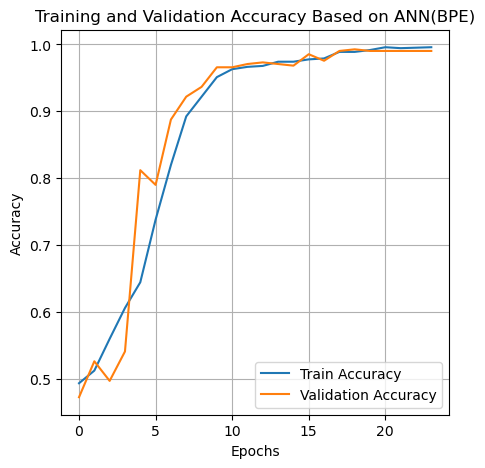

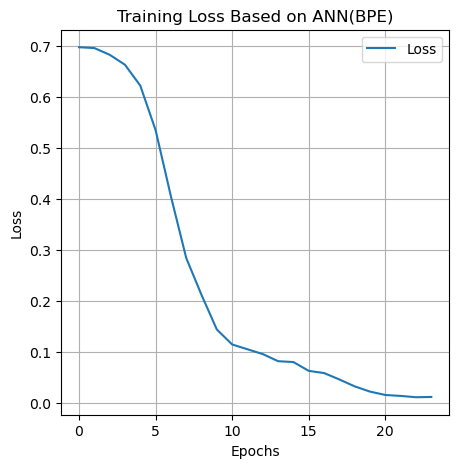

In [2]:
import pickle
import matplotlib.pyplot as plt

# 加载保存的训练指标
with open('/home/qiansongping/Experimental_Fish_3/6.train3/Result21000/GRU_attention_training_metrics05.pkl', 'rb') as f:
    metrics = pickle.load(f)

train_accuracies = metrics['train_accuracies']
val_accuracies = metrics['val_accuracies']
losses = metrics['losses']

# 绘制训练集精度和验证集精度
plt.figure(figsize=(5, 5))
# plt.ylim(0, 1.0)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Based on ANN(BPE)')
plt.legend()
plt.grid()
# plt.savefig('train_acc_ANN_3mer.png',dpi=300)
plt.show()

# 绘制损失情况
plt.figure(figsize=(5, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Based on ANN(BPE)')
plt.legend()
plt.grid()
# plt.savefig('train_loss_ANN_3mer.png',dpi=300)
plt.show()

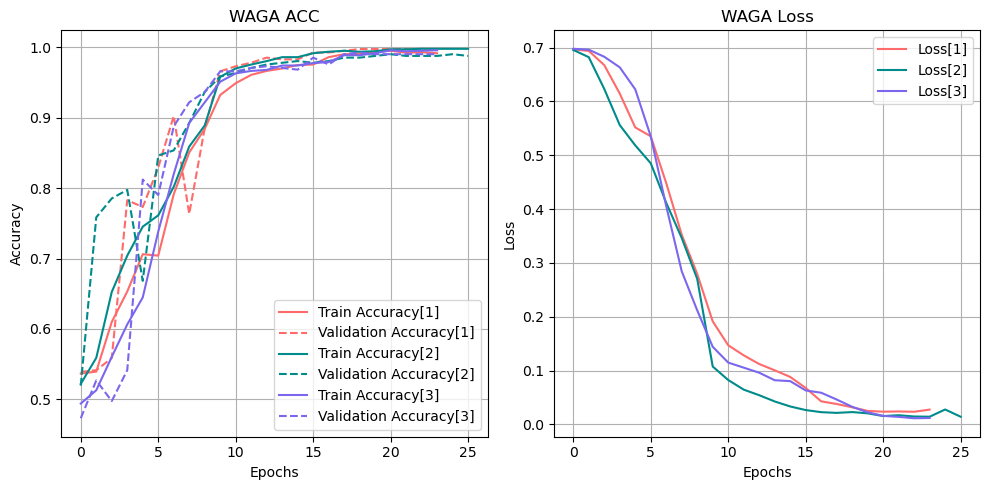

In [ ]:
import pickle
import matplotlib.pyplot as plt

# 加载保存的训练指标
with open('/home/qiansongping/Experimental_Fish_3/6.train1/Result21000/GRU_attention_training_metrics05.pkl', 'rb') as f:
    metrics1 = pickle.load(f)

with open('/home/qiansongping/Experimental_Fish_3/6.train2/Result21000/GRU_attention_training_metrics05.pkl', 'rb') as f:
    metrics2 = pickle.load(f)

with open('/home/qiansongping/Experimental_Fish_3/6.train3/Result21000/GRU_attention_training_metrics05.pkl', 'rb') as f:
    metrics3 = pickle.load(f)

train_accuracies1 = metrics1['train_accuracies']
val_accuracies1 = metrics1['val_accuracies']
losses1 = metrics1['losses']

train_accuracies2 = metrics2['train_accuracies']
val_accuracies2 = metrics2['val_accuracies']
losses2 = metrics2['losses']

train_accuracies3 = metrics3['train_accuracies']
val_accuracies3 = metrics3['val_accuracies']
losses3 = metrics3['losses']

# 绘制训练集精度和验证集精度
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# 绘制训练集精度和验证集精度
axs[0].plot(train_accuracies1, label='Train Accuracy[1]', color='#FF6A6A')
axs[0].plot(val_accuracies1, label='Validation Accuracy[1]', color='#FF6A6A', linestyle='--')
axs[0].plot(train_accuracies2, label='Train Accuracy[2]', color='#008B8B')
axs[0].plot(val_accuracies2, label='Validation Accuracy[2]', color='#008B8B', linestyle='--')
axs[0].plot(train_accuracies3, label='Train Accuracy[3]', color='#7A67EE')
axs[0].plot(val_accuracies3, label='Validation Accuracy[3]', color='#7A67EE', linestyle='--')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('WAGA ACC')
axs[0].legend()
axs[0].grid()

# 绘制损失情况
axs[1].plot(losses1, label='Loss[1]', color='#FF6A6A')
axs[1].plot(losses2, label='Loss[2]', color='#008B8B')
axs[1].plot(losses3, label='Loss[3]', color='#7A67EE')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_title('WAGA Loss')
axs[1].legend()
axs[1].grid()

# 调整布局并保存图像
plt.tight_layout()
plt.savefig('train_acc_loss_WAGA.pdf', dpi=500)
plt.savefig('train_acc_loss_WAGA.png', dpi=500)
plt.show()

#### 模型测试

In [1]:
import pandas as pd
import numpy as np
import gensim
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from itertools import islice
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
import pickle
import warnings

# 5. 构建数据加载器
class TextClassificationDataset(Dataset):
    def __init__(self, X, y, length):
        self.X = X
        self.y = y
        self.length = length
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.length[idx]

class GRUClassifierWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout, num_heads):
        super(GRUClassifierWithAttention, self).__init__()

        self.lstm = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim * 2 if bidirectional else hidden_dim, num_heads=num_heads)
        self.fc1 = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, hidden_dim)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, lengths):
        packed_sequence = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.lstm(packed_sequence)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        # 使用自注意力机制
        attention_output, attention_weights = self.attention(output.permute(1, 0, 2), output.permute(1, 0, 2), output.permute(1, 0, 2))
        attention_output = attention_output.permute(1, 0, 2)

        out = self.fc1(attention_output[:, -1, :])  # 使用最后一个时间步的输出
        out = self.tanh(out)
        out = self.fc2(out)
        
        return out, attention_weights

In [2]:
# 4. 读取预处理训练集、验证集和测试集
file_path =  '/home/qiansongping/Experimental_Fish_3/6.train3/Vectors_21000'
test_X, test_y, test_length= torch.load(f'{file_path}/test_sentences_tensor.pth'),torch.load(f'{file_path}/test_labels_tensor.pth'),torch.load(f'{file_path}/test_lengths_tensor.pth')
batch_size = 4
test_dataset = TextClassificationDataset(test_X, test_y, test_length)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
import torch
from sklearn.preprocessing import minmax_scale
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# 加载模型
input_dim = 100  # 假设有200个词
hidden_dim = 8
output_dim = 2  # 假设二分类问题
num_layers = 1
bidirectional = True
dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BiLSTM_model =  GRUClassifierWithAttention(input_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout,num_heads=1).to(device)
BiLSTM_model.load_state_dict(torch.load('/home/qiansongping/Experimental_Fish_3/6.train3/Result21000/Best_GRU_attention_model05.pth', map_location=device))
BiLSTM_model.eval()



# 在测试集上评估模型
test_predictions = []
test_labels = []

with torch.no_grad():
    for batch_data, batch_labels,batch_lengths in test_loader:
        packed_inputs, labels = torch.tensor(batch_data,dtype=torch.float32), batch_labels
        packed_inputs = packed_inputs.to(device)
        labels = labels.to(device)
        lengths = batch_lengths.to('cpu')
                
        outputs,weights = BiLSTM_model(packed_inputs, lengths)
        
        # print(minmax_scale(sum(weights[0]).cpu().numpy()))
        
        # 计算验证集上的准确率
        _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#         _, predicted = torch.max(outputs, 1)
        test_predictions.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# 计算常用的测试指标
accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions, average='macro')
recall = recall_score(test_labels, test_predictions, average='macro')
f1 = f1_score(test_labels, test_predictions, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

/home/qiansongping/anaconda3/envs/Pytorch/lib/python3.11/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/tmp/ipykernel_3197/1163706686.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  packed_inputs, labels = torch.tensor(batch_data,dtype=torch.float32), batch_labels


Accuracy: 0.9902
Precision: 0.9902
Recall: 0.9902
F1-score: 0.9902


### 权重求取

#### 权重数据采样

In [1]:
import pandas as pd
import random
import os 
from tqdm import tqdm
import csv
import numpy as np

def process_sample_csv(tsv_file,input_path, output_path, sample_size, num_samples, sample_num):   
    '''
    sample_size:每个样本采样多少个group
    num_samples:采样次数
    sample_num:原始样本数
    '''
    group_empty = {} #存储每个group中没有genebank的物种
    orthogroup = {}   #存储每个group的genebank
    with open(tsv_file,'r', newline='', encoding='utf-8') as file:
        reader = csv.reader(file,delimiter='\t')
        species = next(reader)  #去除列名
        for line in reader:
            group = line[0] #获取聚类号
            group_empty[group] = sum(1 for item in line[1:] if item.strip() == '')
            orthogroup[group] = [item.strip() for items in line[1:] for item in items.split(',') if item.strip()] #获取基因bank号

    # 按照升序进行排序并取出符合条件的数据
    sorted_count = dict(sorted(group_empty.items(), key=lambda item: item[1]))
    genebank = {}
    for group,count in sorted_count.items():
        if (count/sample_num) <= 0.10:
            genebank[group] = orthogroup[group] # 存储每个group的genebank  group: []
        
    a = []
    for _ in range(num_samples):
        random_og_numbers = random.sample(list(genebank.keys()), sample_size) # 随机选择sample_size个group
        for k in random_og_numbers:
            a.append(k)
    
        for file in tqdm(os.listdir(input_path)):
            gk_seq = {}
            if file.endswith('.csv'):
                input_file = os.path.join(input_path,file)
                with open(input_file,'r',newline='',encoding='utf-8') as f1:
                    reader = csv.reader(f1)
                    next(reader)
                    for row in reader:
                            gk_seq[row[0]] = row[2] #gk-->seq

                sample_sequences = [gk_seq[item] for group in random_og_numbers for item in genebank[group] if item in gk_seq]
                sample_group = [group for group in random_og_numbers for item in genebank[group] if item in gk_seq]
                sample_gbank = [item for group in random_og_numbers for item in genebank[group] if item in gk_seq]
                
                sample_string = '<end>'.join(sample_sequences)
                Group_sample = '<end>'.join(sample_group)
                Genebank_sample = '<end>'.join(sample_gbank)
                    
                output_file = os.path.join(output_path, file.replace('.csv', '_sample.csv'))
                
                if not os.path.exists(output_file):
                    with open(output_file,'w', encoding='utf-8') as f:
                        f.write('GeneBank,Group,Sequence\n')  # 表头
                        f.write(f'{Genebank_sample},{Group_sample},{sample_string}\n') #写入第一次采样文件  
                else:
                    with open(output_file,'a', encoding='utf-8') as f:
                        f.write(f'{Genebank_sample},{Group_sample},{sample_string}\n')
    
    p = []
    for j in list(genebank.keys()):
        if j not in a:
            p.append(j)
    print(f'还有{len(p)}条没有被采样到！')


In [2]:
input_path = '/home/qiansongping/Experimental_Fish_3/5.Data_padding/Data'
output_path = '/home/qiansongping/Experimental_Fish_3/New Folder'
tsv_file = '/home/qiansongping/Experimental_Fish_3/2.Orthofinder/Orthogroups.tsv'
sample_size = 14000  #每个样本采样多少个group
num_samples = 3 #采样次数
sample_num = 153 #原始样本数
process_sample_csv(tsv_file,input_path, output_path, sample_size, num_samples, sample_num)

100%|██████████| 128/128 [01:22<00:00,  1.55it/s]


还有0条没有被采样到！


#### 鱼类分类

In [1]:
import shutil
import os 

path = '/home/qiansongping/Experimental_Fish_3/7.weights3/Data_sample'
sea_path = '/home/qiansongping/Experimental_Fish_3/7.weights3/Class/Seawater'
fresh_path = '/home/qiansongping/Experimental_Fish_3/7.weights3/Class/Freshwater'
sea = [215358, 129043, 441366, 181472, 173247, 41447, 2871759, 109905, 80966, 80972, 144197, 7950, 184585, 8049, 80720, 1042646, 586833, 8245, 375764, 241271, 56723, 1203425, 508554, 433405, 229290, 184440, 56716, 8103, 293821, 300413, 310571, 8218, 160734, 52239, 2059687, 72105, 40690, 8267, 195615, 8255, 8262, 52904, 28829, 90069, 27771, 13676, 8236, 8240, 13677, 8175, 161448, 161450, 161453, 109280, 109293, 270530, 161584, 693459, 161469, 161592, 161455, 433684]
fresh = [64144, 158456, 1250792, 390379, 8090, 30732, 147949, 119488, 7994, 42526, 42514, 63155, 8154, 8153, 106582, 32507, 303518, 43689, 299321, 7959, 7955, 1142201, 84645, 369639, 90988, 1606681, 992332, 1582913, 52670, 77115, 33528, 208333, 37003, 105023, 8081, 48698, 48701, 188132, 8083, 8084, 32473, 8010, 409849, 8005, 137520, 42636, 1676925, 113540, 210632, 54343, 417921, 8167, 8168, 283035, 941984, 13013, 337641, 7998, 66913, 310915, 175797, 1234273, 175792, 2290929, 205130, 43700]

In [2]:
for file in os.listdir(path):
    ids = int(file.split('_')[0])
    if ids in sea:
        shutil.copy(os.path.join(path,file),sea_path)
    if ids in fresh:
        shutil.copy(os.path.join(path,file),fresh_path)
print('数据划分完成！')

数据划分完成！


#### 权重数据合并

In [1]:
import os
import csv
import pandas as pd
from tqdm import tqdm

def merge_and_label_csv_files(folder1_path, folder2_path, output_file):
    # 初始化一个空列表来存储所有数据
    merged_data = []

    # 处理文件夹1中的CSV文件
    for filename in tqdm(os.listdir(folder1_path)):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder1_path, filename)
            df = pd.read_csv(file_path)
            df['Label'] = 0  # 添加Label列
            merged_data.append(df)

    # 处理文件夹2中的CSV文件
    for filename in tqdm(os.listdir(folder2_path)):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder2_path, filename)
            df = pd.read_csv(file_path)
            df['Label'] = 1  # 添加Label列
            merged_data.append(df)

    # 合并所有数据
    final_data = pd.concat(merged_data, ignore_index=True)

    # 将合并后的数据写入新的CSV文件
    final_data.to_csv(output_file, index=False)

    print("合并完成并已保存到", output_file)

In [2]:
folder1_path = '/home/qiansongping/Experimental_Fish_3/7.weights3/Class/Freshwater'
folder2_path = '/home/qiansongping/Experimental_Fish_3/7.weights3/Class/Seawater'
output_file = '/home/qiansongping/Experimental_Fish_3/7.weights3/Merge/Seqence_merge_Label_weight.csv'
merge_and_label_csv_files(folder1_path, folder2_path, output_file)

100%|██████████| 62/62 [00:29<00:00,  2.11it/s]


合并完成并已保存到 /home/qiansongping/Experimental_Fish_3/7.weights3/Merge/Seqence_merge_Label_weight.csv


#### 权重求取

In [ ]:
import pandas as pd
import numpy as np
import gensim
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.preprocessing import minmax_scale
import warnings
import csv
import shutil
import multiprocessing as mp

warnings.filterwarnings("ignore")

# 全局变量，用于在子进程中共享模型
word2vec_model = None
best_model = None

class GRUClassifierWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout, num_heads):
        super(GRUClassifierWithAttention, self).__init__()

        self.lstm = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim * 2 if bidirectional else hidden_dim, num_heads=num_heads)
        self.fc1 = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, hidden_dim)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, lengths):
        packed_sequence = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.lstm(packed_sequence)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        attention_output, attention_weights = self.attention(output.permute(1, 0, 2), output.permute(1, 0, 2), output.permute(1, 0, 2))
        attention_output = attention_output.permute(1, 0, 2)

        out = self.fc1(attention_output[:, -1, :])  # 使用最后一个时间步的输出
        out = self.tanh(out)
        out = self.fc2(out)
        
        return out, attention_weights

def preprocess_data(doc, max_sentences):
    global word2vec_model
    sentences_per_sample = doc.split("<end>")
    length = len(sentences_per_sample)
    if length >= max_sentences:
        length = max_sentences

    sentences_per_sample = ['<start> '+ sentence.replace("Ġ", "").strip() +' <end>' for sentence in sentences_per_sample]
    sentences_vectors = []
    for sentence in sentences_per_sample:
        words = sentence.split()
        word_vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
        if word_vectors:
            sentence_vector = np.mean(word_vectors, axis=0)  # 句子向量取平均
        else:
            sentence_vector = np.zeros(word_vectors.shape[1])  # 如果句子中没有匹配的词，使用零向量
        sentences_vectors.append(sentence_vector)

    if len(sentences_vectors) < max_sentences:
        padding = [np.zeros(word2vec_model.vector_size)] * (max_sentences - len(sentences_vectors))
        sentences_vectors.extend(padding)
    else:
        sentences_vectors = sentences_vectors[:max_sentences]
    return torch.tensor([sentences_vectors]), torch.tensor([length])

def process_row(row, max_sentences):
    global best_model
    correct = 0
    un_correct = 0
    group_weight = {}
    Gp_weight = {}

    with torch.no_grad():
        GPs = row[1].split('<end>')[0:max_sentences]  # Group
        doc = row[-2]  # Sequence
        label = int(row[-1])

        doc_vector, length = preprocess_data(doc, max_sentences)
        outputs, weights = best_model(torch.tensor(doc_vector.to('cpu'),dtype=torch.float32), length.to('cpu'))
        _, predicted = torch.max(outputs.data, 1)
        predicted_label = int(predicted[0].numpy())

        if predicted_label == label:
            correct += 1
            Normalized_weights = list(minmax_scale(sum(weights[0]).cpu().numpy()))

            for index, GP in enumerate(GPs):
                Normalized_weight = Normalized_weights[index]
                if GP in group_weight.keys():
                    group_weight[GP] += Normalized_weight
                else:
                    group_weight[GP] = Normalized_weight

            for index, Gp in enumerate(GPs):
                Normalized_weight = Normalized_weights[index]
                if Gp not in Gp_weight.keys():
                    Gp_weight[Gp] = [Normalized_weight]
                else:
                    Gp_weight[Gp].append(Normalized_weight)
        else:
            un_correct += 1

    return correct, un_correct, group_weight, Gp_weight

def update_global_weights(global_group_weight, global_Gp_weight, group_weight, Gp_weight):
    for key, value in group_weight.items():
        if key in global_group_weight:
            global_group_weight[key] += value
        else:
            global_group_weight[key] = value

    for key, value_list in Gp_weight.items():
        if key in global_Gp_weight:
            global_Gp_weight[key].extend(value_list)
        else:
            global_Gp_weight[key] = value_list

def init_model(word2vec_model_path, best_model_path, input_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout, num_heads):
    global word2vec_model, best_model
    word2vec_model = gensim.models.KeyedVectors.load(word2vec_model_path)
    best_model = GRUClassifierWithAttention(input_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout, num_heads)
    best_model.load_state_dict(torch.load(best_model_path))
    best_model.eval()

def main():
    input_dim = 100
    hidden_dim = 8
    output_dim = 2
    num_layers = 1
    bidirectional = True
    dropout = 0.5
    num_heads = 1

    input_path = '/home/qiansongping/Experimental_Fish_3/5.Data_padding/2025_Data_merge/Seqence_merge_Label.csv'
    best_model_path = '/home/qiansongping/Experimental_Fish_3/6.train1/Result/Best_GRU_attention_model05.pth'
    word2vec_model_path = "/home/qiansongping/Experimental_Fish_3/4.BPE/bpe_results/word2vec_model_cbow.model"

    max_sentences = 21000

    input_file = pd.read_csv(input_path).values  # Convert to numpy array for easier row processing

    global_group_weight = {}
    global_Gp_weight = {}
    global_correct = 0
    global_un_correct = 0

    # Setup multiprocessing
    pool = mp.Pool(processes=8, initializer=init_model, initargs=(word2vec_model_path, best_model_path, input_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout, num_heads))
    results = []

    for row in tqdm(input_file):
        result = pool.apply_async(process_row, args=(row, max_sentences))
        results.append(result)

    pool.close()
    pool.join()

    # Collect results from multiprocessing
    for result in results:
        correct, un_correct, group_weight, Gp_weight = result.get()
        global_correct += correct
        global_un_correct += un_correct
        update_global_weights(global_group_weight, global_Gp_weight, group_weight, Gp_weight)

    # Print accuracy
    print('correct:', global_correct, 'un_correct:', global_un_correct, 'Acc:', global_correct / (global_correct + global_un_correct))

    # Write results to files
    with open('/home/qiansongping/Experimental_Fish_3/7.weights2/Result/BPE_weight_group_sum.csv', 'a') as file:
        writer = csv.writer(file)
        writer.writerow(['group', 'weight'])
        for key in global_group_weight.keys():
            weight = global_group_weight[key]
            writer.writerow([key, weight])

    with open('/home/qiansongping/Experimental_Fish_3/7.weights2/Result/BPE_weight_group_mean.csv', 'a') as file:
        writer = csv.writer(file)
        writer.writerow(['Group', 'Sum_weight', 'Mean_weight'])
        for key in global_Gp_weight.keys():
            weight = global_Gp_weight[key]
            writer.writerow([key, float(sum(weight)), float(sum(weight) / len(weight))])

if __name__ == "__main__":
    main()
    print('All Done!')


#### 128真实物种

In [3]:
import os
import csv
import pandas as pd
from tqdm import tqdm

def path(file_path, file_out):
    for filename in tqdm(os.listdir(file_path)):
        file = os.path.join(file_path, filename)
        out = os.path.join(file_out, filename)
        df = pd.read_csv(file)
        gb = '<end>'.join(list(df['GenBank']))
        gp = '<end>'.join(list(df['Group']))
        seq = '<end>'.join(list(df['Sequence']))
        with open(out, 'a') as f:
            writer = csv.writer(f)
            writer.writerow(['GenBank', 'Group', 'Sequence'])
            writer.writerow([gb, gp, seq])
        f.close()

In [4]:
folder1_path = '/home/qiansongping/Experimental_Fish_3/5.Data_padding/2025_7_5/Freshwater'
filder1_out = '/home/qiansongping/Experimental_Fish_3/5.Data_padding/2025_Data_merge/Freshwater'
folder2_path = '/home/qiansongping/Experimental_Fish_3/5.Data_padding/2025_7_5/Seawater'
filder2_out = '/home/qiansongping/Experimental_Fish_3/5.Data_padding/2025_Data_merge/Seawater'
path(folder1_path, filder1_out)
path(folder2_path, filder2_out)

100%|██████████| 62/62 [00:29<00:00,  2.09it/s]


In [5]:
import pandas as pd
path = '/home/qiansongping/Experimental_Fish_3/5.Data_padding/2025_Data_merge/Seqence_merge_Label.csv'
df = pd.read_csv(path)
df.head()

,GenBank,Group,Sequence,Label
0,XP_015797672.2<end>XP_015798558.2<end>XP_01580...,OG0000000<end>OG0000000<end>OG0000000<end>OG00...,ĠM LLED NIV TFV KN ELKK CQK LLD PD YPE SQRV DE...,0
1,XP_004552115.1<end>XP_004556660.1<end>XP_00456...,OG0000000<end>OG0000000<end>OG0000000<end>OG00...,ĠM SLC ENKV EL PPP SK ATL CGD EI TKA QSP EK QH...,0
2,XP_018581252.1<end>XP_018587939.2<end>XP_01859...,OG0000000<end>OG0000000<end>OG0000000<end>OG00...,ĠM SLRG EH EEG SA FSA MCL YG ELEE SDSN SEAG AY...,0
3,XP_056303833.1<end>XP_056304256.1<end>XP_05630...,OG0000000<end>OG0000000<end>OG0000000<end>OG00...,ĠM DLS DL HR EED SC FEP SCV SM KSD Q SMD PP VQ...,0
4,XP_044024083.1<end>XP_044024084.1<end>XP_04402...,OG0000000<end>OG0000000<end>OG0000000<end>OG00...,ĠM DQ CED REE GV PPSK TSL CG EH GT RT RA QSP E...,0


100%|██████████| 128/128 [00:00<00:00, 89747.73it/s]


correct: 123 un_correct: 5 Acc: 0.9609375

Accuracy:  0.9609
Precision: 0.9254
Recall:    1.0000
F1 Score:  0.9612


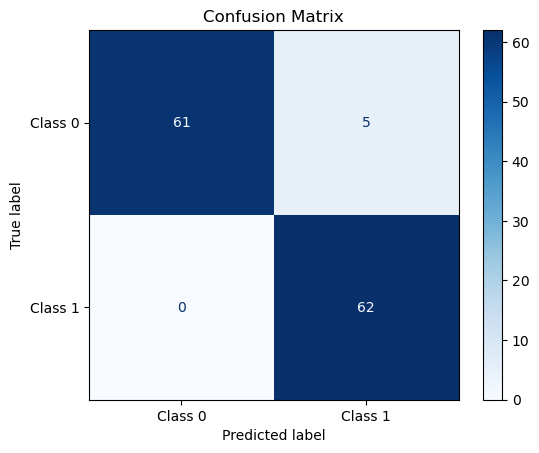

[           inf 9.98000801e-01 9.97933865e-01 9.97929335e-01
 9.96683061e-01 9.96587276e-01 9.93013442e-01 9.92572010e-01
 9.60028470e-01 9.37902272e-01 9.28256929e-01 4.66077938e-04
 4.66076599e-04 4.66076366e-04 4.66076133e-04]


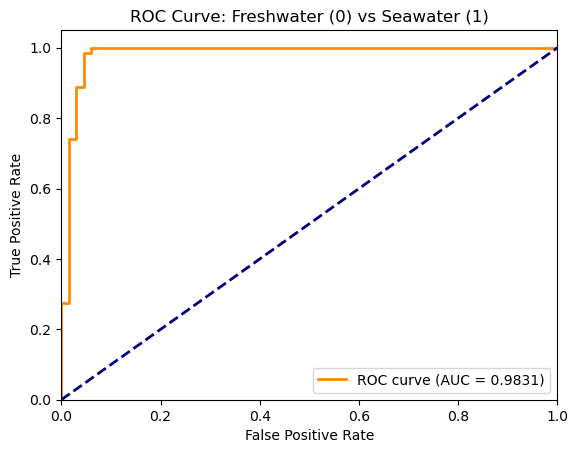

All Done!


In [1]:
import pandas as pd
import numpy as np
import gensim
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.preprocessing import minmax_scale
import warnings
import csv
import shutil
import multiprocessing as mp
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# 全局变量，用于在子进程中共享模型
word2vec_model = None
best_model = None

class GRUClassifierWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout, num_heads):
        super(GRUClassifierWithAttention, self).__init__()

        self.lstm = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim * 2 if bidirectional else hidden_dim, num_heads=num_heads)
        self.fc1 = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, hidden_dim)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, lengths):
        packed_sequence = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.lstm(packed_sequence)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        attention_output, attention_weights = self.attention(output.permute(1, 0, 2), output.permute(1, 0, 2), output.permute(1, 0, 2))
        attention_output = attention_output.permute(1, 0, 2)

        out = self.fc1(attention_output[:, -1, :])  # 使用最后一个时间步的输出
        out = self.tanh(out)
        out = self.fc2(out)
        
        return out, attention_weights

def preprocess_data(doc, max_sentences):
    global word2vec_model
    sentences_per_sample = doc.split("<end>")
    length = len(sentences_per_sample)
    if length >= max_sentences:
        length = max_sentences

    sentences_per_sample = ['<start> '+ sentence.replace("Ġ", "").strip() +' <end>' for sentence in sentences_per_sample]
    sentences_vectors = []
    for sentence in sentences_per_sample:
        words = sentence.split()
        word_vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
        if word_vectors:
            sentence_vector = np.mean(word_vectors, axis=0)  # 句子向量取平均
        else:
            sentence_vector = np.zeros(word_vectors.shape[1])  # 如果句子中没有匹配的词，使用零向量
        sentences_vectors.append(sentence_vector)

    if len(sentences_vectors) < max_sentences:
        padding = [np.zeros(word2vec_model.vector_size)] * (max_sentences - len(sentences_vectors))
        sentences_vectors.extend(padding)
    else:
        sentences_vectors = sentences_vectors[:max_sentences]
    return torch.tensor([sentences_vectors]), torch.tensor([length])

def process_row(row, max_sentences):
    global best_model
    correct = 0
    un_correct = 0
    group_weight = {}
    Gp_weight = {}
    y_true_list = []
    y_pred_list = []
    y_score_list = []  # 新增

    with torch.no_grad():
        GPs = row[1].split('<end>')[0:max_sentences]
        doc = row[-2]
        label = int(row[-1])

        doc_vector, length = preprocess_data(doc, max_sentences)
        outputs, weights = best_model(torch.tensor(doc_vector.to('cpu'), dtype=torch.float32), length.to('cpu'))
        probs = F.softmax(outputs, dim=1)  # 获取预测概率
        predicted_label = int(torch.argmax(probs, dim=1)[0].item())
        positive_prob = float(probs[0][1].item())  # 类别1（海水鱼）的概率

        y_true_list.append(label)
        y_pred_list.append(predicted_label)
        y_score_list.append(positive_prob)  # 新增

        if predicted_label == label:
            correct += 1
            Normalized_weights = list(minmax_scale(sum(weights[0]).cpu().numpy()))
            for index, GP in enumerate(GPs):
                Normalized_weight = Normalized_weights[index]
                group_weight[GP] = group_weight.get(GP, 0) + Normalized_weight
                Gp_weight.setdefault(GP, []).append(Normalized_weight)
        else:
            un_correct += 1

    return correct, un_correct, group_weight, Gp_weight, y_true_list, y_pred_list, y_score_list

def update_global_weights(global_group_weight, global_Gp_weight, group_weight, Gp_weight):
    for key, value in group_weight.items():
        if key in global_group_weight:
            global_group_weight[key] += value
        else:
            global_group_weight[key] = value

    for key, value_list in Gp_weight.items():
        if key in global_Gp_weight:
            global_Gp_weight[key].extend(value_list)
        else:
            global_Gp_weight[key] = value_list

def init_model(word2vec_model_path, best_model_path, input_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout, num_heads):
    global word2vec_model, best_model
    word2vec_model = gensim.models.KeyedVectors.load(word2vec_model_path)
    best_model = GRUClassifierWithAttention(input_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout, num_heads)
    best_model.load_state_dict(torch.load(best_model_path))
    best_model.eval()

def main():
    input_dim = 100
    hidden_dim = 8
    output_dim = 2
    num_layers = 1
    bidirectional = True
    dropout = 0.5
    num_heads = 1

    input_path = '/home/qiansongping/Experimental_Fish_3/5.Data_padding/2025_Data_merge/Seqence_merge_Label.csv'
    best_model_path = '/home/qiansongping/Experimental_Fish_3/6.train1/Result21000/Best_GRU_attention_model05.pth'
    word2vec_model_path = "/home/qiansongping/Experimental_Fish_3/4.BPE/bpe_results/word2vec_model_cbow.model"

    max_sentences = 21000

    input_file = pd.read_csv(input_path).values  # Convert to numpy array for easier row processing

    global_group_weight = {}
    global_Gp_weight = {}
    global_correct = 0
    global_un_correct = 0
    all_y_true = []
    all_y_pred = []
    all_y_score = []  # 新增

    # Setup multiprocessing
    pool = mp.Pool(processes=8, initializer=init_model, initargs=(word2vec_model_path, best_model_path, input_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout, num_heads))
    results = []

    for row in tqdm(input_file):
        result = pool.apply_async(process_row, args=(row, max_sentences))
        results.append(result)

    pool.close()
    pool.join()

    # Collect results from multiprocessing
    for result in results:
        correct, un_correct, group_weight, Gp_weight, y_true_list, y_pred_list, y_score_list = result.get()
        global_correct += correct
        global_un_correct += un_correct
        update_global_weights(global_group_weight, global_Gp_weight, group_weight, Gp_weight)
        all_y_true.extend(y_true_list)
        all_y_pred.extend(y_pred_list)
        all_y_score.extend(y_score_list)  # 新增

    print('correct:', global_correct, 'un_correct:', global_un_correct, 'Acc:', global_correct / (global_correct + global_un_correct))

    # 计算评估指标
    acc = accuracy_score(all_y_true, all_y_pred)
    precision = precision_score(all_y_true, all_y_pred, average='binary')
    recall = recall_score(all_y_true, all_y_pred, average='binary')
    f1 = f1_score(all_y_true, all_y_pred, average='binary')

    print(f"\nAccuracy:  {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    # 绘制混淆矩阵图
    cm = confusion_matrix(all_y_true, all_y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])  #fresh--0 and sea--1
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.savefig('/home/qiansongping/Experimental_Fish_3/7.weights7_5/confusion_matrix1.png', dpi=300)  # 保存图像
    plt.show()
     
    # 计算ROC曲线和AUC
    fpr, tpr, thresholds = roc_curve(all_y_true, all_y_score)
    roc_auc = auc(fpr, tpr)
    print(thresholds)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve: Freshwater (0) vs Seawater (1)')
    plt.legend(loc='lower right')
    plt.savefig('/home/qiansongping/Experimental_Fish_3/7.weights7_5/roc_curve1.png', dpi=300)
    plt.show()

    # # Write results to files
    # with open('/home/qiansongping/Experimental_Fish_3/7.weights7_5/BPE_weight_group_sum.csv', 'a') as file:
    #     writer = csv.writer(file)
    #     writer.writerow(['group', 'weight'])
    #     for key in global_group_weight.keys():
    #         weight = global_group_weight[key]
    #         writer.writerow([key, weight])

    # with open('/home/qiansongping/Experimental_Fish_3/7.weights7_5/BPE_weight_group_mean.csv', 'a') as file:
    #     writer = csv.writer(file)
    #     writer.writerow(['Group', 'Sum_weight', 'Mean_weight'])
    #     for key in global_Gp_weight.keys():
    #         weight = global_Gp_weight[key]
    #         writer.writerow([key, float(sum(weight)), float(sum(weight) / len(weight))])

if __name__ == "__main__":
    main()
    print('All Done!')


#### 权重结果处理

In [1]:
import os
from Bio import SeqIO
import csv
from tqdm import tqdm
import sys
import shutil
from collections import Counter
csv.field_size_limit(sys.maxsize)

131072

In [2]:
sea = [215358, 129043, 441366, 181472, 173247, 41447, 2871759, 109905, 80966, 80972, 144197, 7950, 184585, 8049, 80720, 1042646, 586833, 8245, 375764, 241271, 56723, 1203425, 508554, 433405, 229290, 184440, 56716, 8103, 293821, 300413, 310571, 8218, 160734, 52239, 2059687, 72105, 40690, 8267, 195615, 8255, 8262, 52904, 28829, 90069, 27771, 13676, 8236, 8240, 13677, 8175, 161448, 161450, 161453, 109280, 109293, 270530, 161584, 693459, 161469, 161592, 161455, 433684]
fresh = [64144, 158456, 1250792, 390379, 8090, 30732, 147949, 119488, 7994, 42526, 42514, 63155, 8154, 8153, 106582, 32507, 303518, 43689, 299321, 7959, 7955, 1142201, 84645, 369639, 90988, 1606681, 992332, 1582913, 52670, 77115, 33528, 208333, 37003, 105023, 8081, 48698, 48701, 188132, 8083, 8084, 32473, 8010, 409849, 8005, 137520, 42636, 1676925, 113540, 210632, 54343, 417921, 8167, 8168, 283035, 941984, 13013, 337641, 7998, 66913, 310915, 175797, 1234273, 175792, 2290929, 205130, 43700]

path = '/home/qiansongping/Experimental_Fish_3/2.Orthofinder/Data_og'
for file in os.listdir(path):
    file_path = os.path.join(path,file)
    if int(file.split('_')[0]) in sea:
        shutil.copy(file_path,'/home/qiansongping/Experimental_Fish_3/8.Results/Class/Seawater')
    if int(file.split('_')[0]) in fresh:
        shutil.copy(file_path,'/home/qiansongping/Experimental_Fish_3/8.Results/Class/Freshwater')

In [2]:
tsv_path = "/home/qiansongping/Experimental_Fish_3/2.Orthofinder/Orthogroups.tsv" # 153个物种

group_empty = {} #存储每个group中没有genebank的物种
orthogroup = {}   #存储每个group的genebank
with open(tsv_path,'r', newline='', encoding='utf-8') as file:
    reader = csv.reader(file,delimiter='\t')
    species = next(reader)  #去除列名
    for line in reader:
        group = line[0] #获取聚类号
        genebank = line[1:] #获取基因bank号
        group_empty[group] = sum(1 for item in genebank if item.strip() == '')
        orthogroup[group] = genebank

# 按照升序进行排序并取出数据
sorted_count = dict(sorted(group_empty.items(), key=lambda item: item[1]))
group_dict = {}
for group,count in sorted_count.items():
    if (count/153) <= 0.10:
        gene_bank = [item.strip() for items in orthogroup[group] for item in items.split(',') if item.strip()] #把所有符合条件的genebank号按照group号顺序合在一个字典中
        group_dict[group] = gene_bank

In [3]:
def find_faa_files(directory,pattern):
  for root, dirs, files in os.walk(directory):
    for file in files:
      if file.endswith(pattern):
        yield os.path.join(root, file)

In [12]:
Group_weight = {}
group_path = '/home/qiansongping/Experimental_Fish_3/7.weights3/Result/BPE_weight_group_sum.csv'
with open(group_path,'r',newline='',encoding='utf-8') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        Gp = row[0]
        weight = row[1]
        Group_weight[Gp] = weight  #group--->weight
sorted_group = dict(sorted(Group_weight.items(), key=lambda item: float(item[1]), reverse=True))

In [5]:
fresh_path = '/home/qiansongping/Experimental_Fish_3/8.Results/Class/Freshwater'
sea_path = '/home/qiansongping/Experimental_Fish_3/8.Results/Class/Seawater'

fresh_gk_name = {}
sea_gk_name = {}

for file in tqdm(find_faa_files(fresh_path,'.faa'),desc='Fresh'):
    for record in SeqIO.parse(file,'fasta'):
        Genebank = record.id
        Gename = record.description.split()[1].strip()
        fresh_gk_name[Genebank] = Gename

for file in tqdm(find_faa_files(sea_path,'.faa'),desc='Sea'):
    for record in SeqIO.parse(file,'fasta'):
        Genebank = record.id
        Gename = record.description.split()[1].strip()
        sea_gk_name[Genebank] = Gename

Fresh: 66it [00:07,  8.83it/s]
Sea: 62it [00:06,  8.96it/s]


In [29]:
with open('/home/qiansongping/Experimental_Fish_3/8.Results/weight_result/weight_class1.csv','w') as f:
    writer = csv.writer(f)
    writer.writerow(['Group','Weight','Freshfish','Seafish'])
    for key in tqdm(list(sorted_group.keys())[:500]):
        gks = group_dict[key]

        fresh_fish = [fresh_gk_name[gk] for gk in gks if gk in fresh_gk_name]
        sea_fish = [sea_gk_name[gk] for gk in gks if gk in sea_gk_name]

        fresh_name = [n for n in fresh_fish if not n.startswith('LOC')]
        Sea_name = [n for n in sea_fish if not n.startswith('LOC')]
      
        writer.writerow([key,Group_weight[key],','.join(fresh_name),','.join(Sea_name)])

100%|██████████| 500/500 [00:00<00:00, 1796.71it/s]


In [13]:
with open('/home/qiansongping/Experimental_Fish_3/8.Results/weight_result/weight_class3_LOC.csv','w') as f:
    writer = csv.writer(f)
    writer.writerow(['Group','Weight','Freshfish','Seafish'])
    for key in tqdm(list(sorted_group.keys())[:500]):
        gks = group_dict[key]

        fresh_fish = [fresh_gk_name[gk] for gk in gks if gk in fresh_gk_name]
        sea_fish = [sea_gk_name[gk] for gk in gks if gk in sea_gk_name]
      
        writer.writerow([key,Group_weight[key],','.join(fresh_fish),','.join(sea_fish)])

100%|██████████| 500/500 [00:00<00:00, 1534.47it/s]


In [14]:
with open('/home/qiansongping/Experimental_Fish_3/8.Results/weight_result/weight_class3_gk.csv','w') as f:
    writer = csv.writer(f)
    writer.writerow(['Group','Weight','Freshfish','Seafish'])
    for key in tqdm(list(sorted_group.keys())[:500]):
        gks = group_dict[key]

        fresh_fish = [gk for gk in gks if gk in fresh_gk_name]
        sea_fish = [gk for gk in gks if gk in sea_gk_name]
      
        writer.writerow([key,Group_weight[key],','.join(fresh_fish),','.join(sea_fish)])

  0%|          | 0/500 [00:00<?, ?it/s]100%|██████████| 500/500 [00:00<00:00, 1569.31it/s]


#### 共有Group求取处理

In [1]:
import pandas as pd
import os
import csv

In [2]:
data1 = pd.read_excel('/home/qiansongping/Experimental_Fish_3/8.Results/weight_result/result_total.xlsx', sheet_name='weight_class1')
data1

,Group,Weight,Freshfish,Seafish
0,OG0000377,550.735530,"tmsb1,tmsb2,tmsb4x,tmsb1,tmsb1,tmsb4x,tmsb,tms...","tmsb4x,tmsb2,tmsb2,tmsb2,tmsb1,tmsb4x,tmsb2,tm..."
1,OG0000018,478.154570,"zgc:153846,crygm4,zgc:153846,crygm2e,crygm5,cr...","crygm5,crygm5,crygm5,crygm1,zgc:153846,crygm3,..."
2,OG0000012,303.865330,"ano9a,zgc:114046,zgc:114046,zgc:92591,zgc:1140...","zgc:92591,zgc:92591"
3,OG0000052,273.538850,"zgc:174624,zbtb49,znf436,zgc:113030,si:dkeyp-2...","znf713,znf648,znf41"
4,OG0014306,170.036330,"si:ch211-22i13.2,si:ch211-22i13.2,si:ch211-22i...","si:ch211-22i13.2,si:ch211-22i13.2,si:ch211-22i..."
...,...,...,...,...
495,OG0002739,0.745584,"rpl22,rpl22,rpl22,rpl22,rpl22,rpl22,rpl22,rpl2...","rpl22,rpl22,rpl22,rpl22,rpl22,rpl22,rpl22,rpl2..."
496,OG0000900,0.744194,"hnrnpa3,hnrnpa1b,hnrnpa3,hnrnpa1b,hnrnpa3,hnrn...","hnrnpa3,hnrnpa1b,hnrnpa3,hnrnpa3,hnrnpa3,hnrnp..."
497,OG0006933,0.742997,"atxn7l3a,atxn7l3a,atxn7l3a,atxn7l3a,atxn7l3a,a...","atxn7l3a,atxn7l3a,atxn7l3a,atxn7l3a,atxn7l3,at..."
498,OG0003754,0.741747,"ell3,ell3",NaN


In [3]:
data2 = pd.read_excel('/home/qiansongping/Experimental_Fish_3/8.Results/weight_result/result_total.xlsx', sheet_name='weight_class2')
data2

,Group,Weight,Freshfish,Seafish
0,OG0000014,1805.970700,"si:dkey-108k21.19,h2ax1,hist1h2a2,hist1h2a4,hi...",NaN
1,OG0000012,619.796750,"ano9a,zgc:114046,zgc:114046,zgc:92591,zgc:1140...","zgc:92591,zgc:92591"
2,OG0000000,589.348700,"si:ch73-168d20.1,nlrc7,nlrp12l,si:dkey-13n15.1...","si:ch211-233m11.1,si:ch211-11p18.6,si:ch211-23..."
3,OG0000030,464.349880,"zgc:163061,zgc:153405,zgc:110216,zgc:110425,zg...",NaN
4,OG0000117,287.429800,"tpm3,tpm1,tpm4a,tpm2,tpm1,tpm4a,tpm2,tpm2,tpm4...","tpm3,tpm2,tpm1,tpm4a,tpm3,tpm1,tpm2,tpm4a,tpm2..."
...,...,...,...,...
495,OG0000488,32.601930,"fhod3a,fhod3b,fhod3b,fhod3a,fhod1,fhod3a,fhod3...","fhod3a,fhod1,fhod3b,fhod1,fhod1,fhod3b,fhod3a,..."
496,OG0001842,32.523150,"foxo3a,foxo3b,foxo3a,foxo3b,foxo3b,foxo3a,foxo...","foxo3b,foxo3a,foxo3a,foxo3a,foxo3a,foxo3b,foxo..."
497,OG0006921,32.484234,"sp5l,sp5l,sp5l,sp5l,sp5l,sp5l,sp5l,sp5l,sp5l,s...","sp5l,sp5l,sp5l,sp5l,sp5l,sp5l,sp5l,sp5l,sp5l,s..."
498,OG0013100,32.459280,"cep63,cep63,cep63,cep63,cep63,cep63,cep63,cep6...","cep63,cep63,cep63,cep63,cep63,cep63,cep63,cep6..."


In [4]:
data3 = pd.read_excel('/home/qiansongping/Experimental_Fish_3/8.Results/weight_result/result_total.xlsx', sheet_name='weight_class3')
data3

,Group,Weight,Freshfish,Seafish
0,OG0000018,2159.164000,"zgc:153846,crygm4,zgc:153846,crygm2e,crygm5,cr...","crygm5,crygm5,crygm5,crygm1,zgc:153846,crygm3,..."
1,OG0000007,1231.921100,"si:dkeyp-94g1.1,si:cabz01083838.1,asgr2,si:dke...","si:dkey-88n24.6,si:cabz01083838.1"
2,OG0000009,1047.957300,"si:dkeyp-75b4.10,clec19a,clec19a,si:dkey-9i23....","clec19a,si:dkeyp-75b4.10,si:ch211-160b11.4,si:..."
3,OG0000053,690.283300,"zgc:123217,zgc:153968,zgc:165423,zgc:100868,pr...","zgc:123217,zgc:123217,zgc:100868,zgc:123217,zg..."
4,OG0000225,658.474700,"si:dkey-102g19.3,negaly6,negaly6,si:dkey-102g1...","plaur,plaur,plaur,lypd3,plaur,plaur"
...,...,...,...,...
495,OG0000506,14.186881,"cel.1,cel,cel.2,cel.2,cel.2,cel.2,cel.2,cel.2,...","cel.2,cel.2,cel.2,cel.1,cel.2,cel.2,cel.2,cel...."
496,OG0001662,14.181791,"itpk1b,itpk1b,itpk1a,itpk1a,itpk1b,itpk1b,itpk...","itpk1b,itpk1b,itpk1b,itpk1b,itpk1b,itpk1b,itpk..."
497,OG0000436,14.178902,"hs6st3b,hs6st1a,hs6st3b,hs6st1a,hs6st1a,hs6st1...","hs6st1a,hs6st1a,hs6st3b,hs6st3b,hs6st3b,hs6st1..."
498,OG0000933,14.157227,"megf6b,megf6b,megf6,megf6a,megf6b,megf6,megf6a...","megf6b,megf6,megf6,megf6b,megf6b,megf6,megf6,m..."


In [5]:
data = set(list(data1['Group'])) & set(list(data2['Group']))
only = data & set(list(data3['Group']))
print(len(only))

54


In [6]:
fresh = {}
sea = {}
gp = list(data1['Group'])
fr = list(data1['Freshfish'])
se = list(data1['Seafish'])
for i in range(len(gp)):
    fresh[gp[i]] = fr[i]
    sea[gp[i]] = se[i]
    

In [7]:
with open('/home/qiansongping/Experimental_Fish_3/8.Results/Result21000_1.csv','w') as f:
    writer = csv.writer(f)
    writer.writerow(['Group','Freshwater','Seawater'])
    for i in range(len(gp)):
        if gp[i] in only:
            writer.writerow([gp[i],fresh[gp[i]],sea[gp[i]]])

### KEGG富集分析数据准备

In [11]:
import csv
import pandas as pd 
from Bio import SeqIO

#(1)读取orthogroup聚类文件--group-genbank
tsv_path = '/home/qiansongping/Experimental_Fish_3/2.Orthofinder/Orthogroups.tsv'

orthogroup = dict()
with open(tsv_path,'r', newline='', encoding='utf-8') as file:
    reader = csv.reader(file,delimiter='\t')
    species = next(reader)  #去除列名
    print(species[1:])
    print(species[1:].index('7955_protein'))
    for line in reader:
        group = line[0] #获取聚类号
        genebank = line[1:] #获取基因bank号
        orthogroup[group] = genebank

['1042646_protein', '105023_protein', '106582_protein', '109280_protein', '109293_protein', '109905_protein', '113540_protein', '1142201_protein', '118141_protein', '119488_protein', '1203425_protein', '1234273_protein', '1250792_protein', '129043_protein', '13013_protein', '13489_protein', '134920_protein', '13676_protein', '13677_protein', '137520_protein', '144197_protein', '147949_protein', '150288_protein', '1582913_protein', '158456_protein', '159077_protein', '1606681_protein', '160734_protein', '161448_protein', '161450_protein', '161453_protein', '161455_protein', '161469_protein', '161584_protein', '161590_protein', '161592_protein', '1676925_protein', '173247_protein', '175792_protein', '175797_protein', '181472_protein', '1841481_protein', '184440_protein', '184585_protein', '188132_protein', '195615_protein', '205130_protein', '2059687_protein', '208333_protein', '210632_protein', '215358_protein', '2290929_protein', '229290_protein', '241271_protein', '244447_protein', '2

In [12]:
file_path = '/home/qiansongping/Experimental_Fish_3/8.Results/Result21000.csv'
data = pd.read_csv(file_path)
public_group = list(data['Group'])
data.head()

,Group,Freshwater,Seawater
0,OG0000052,"zgc:174624,zbtb49,znf436,zgc:113030,si:dkeyp-2...","znf713,znf648,znf41"
1,OG0000009,"si:dkeyp-75b4.10,clec19a,clec19a,si:dkey-9i23....","clec19a,si:dkeyp-75b4.10,si:ch211-160b11.4,si:..."
2,OG0000007,"si:dkeyp-94g1.1,si:cabz01083838.1,asgr2,si:dke...","si:dkey-88n24.6,si:cabz01083838.1"
3,OG0000018,"zgc:153846,crygm4,zgc:153846,crygm2e,crygm5,cr...","crygm5,crygm5,crygm5,crygm1,zgc:153846,crygm3,..."
4,OG0000017,"zmp:0000000937,si:ch73-111e15.1,si:dkey-187i8....",si:ch211-125e6.14


In [13]:
gk_name = dict()
gk_id = {}
file = '/home/qiansongping/Experimental_Fish_3/2.Orthofinder/Data_og/7955_group.faa'
records = SeqIO.parse(file, 'fasta')
for record in records:
    gk = record.description.split()[0] #genebank
    name = record.description.split()[1] #symbol
    for k in record.description.split():
        if k.startswith("[GeneID="):
            gene_id = k.split('=')[-1].split(']')[0]
    gk_name[gk] = name
    gk_id[gk] = gene_id
    print(record.description.split(),gene_id)

['NP_001104724.2', 'zgc:174180', '[organism=Danio', 'rerio]', '[GeneID=100008100]', 'GP=OG0000000'] 100008100
['NP_001121827.1', 'LOC794656', '[organism=Danio', 'rerio]', '[GeneID=794656]', 'GP=OG0000000'] 794656
['NP_001124145.1', 'zgc:194906', '[organism=Danio', 'rerio]', '[GeneID=100170839]', 'GP=OG0000000'] 100170839
['NP_001137518.1', 'si:dkey-151g22.1', '[organism=Danio', 'rerio]', '[GeneID=564402]', 'GP=OG0000000'] 564402
['NP_001137523.1', 'si:dkey-27n6.1', '[organism=Danio', 'rerio]', '[GeneID=100034375]', 'GP=OG0000000'] 100034375
['NP_001314923.1', 'LOC101883187', '[organism=Danio', 'rerio]', '[GeneID=101883187]', 'GP=OG0000000'] 101883187
['NP_001352668.1', 'si:ch73-50f9.4', '[organism=Danio', 'rerio]', '[GeneID=799740]', 'GP=OG0000000'] 799740
['NP_001410195.1', 'si:ch211-187g4.1', '[organism=Danio', 'rerio]', '[GeneID=110437934]', 'GP=OG0000000'] 110437934
['NP_001410466.1', 'si:dkey-51d8.1', '[organism=Danio', 'rerio]', '[GeneID=108183673]', 'GP=OG0000000'] 108183673
['N

In [14]:
Danio_rerio = dict()
for group,genebank in orthogroup.items():
    if group in public_group:
        Danio_rerio[group] = [g.strip() for g in genebank[118].split(',')]
        print(group,genebank[118].split(','))

OG0000000 ['NP_001104724.2', ' NP_001121827.1', ' NP_001124145.1', ' NP_001137518.1', ' NP_001137523.1', ' NP_001314923.1', ' NP_001352668.1', ' NP_001410195.1', ' NP_001410466.1', ' NP_001410469.1', ' XP_001335224.6', ' XP_001338550.5', ' XP_002660670.3', ' XP_002665163.2', ' XP_003200133.2', ' XP_003200157.2', ' XP_005156549.1', ' XP_005157857.1', ' XP_005157868.1', ' XP_005158670.1', ' XP_005160238.1', ' XP_005160267.1', ' XP_005161560.2', ' XP_005162399.1', ' XP_005164992.1', ' XP_009290195.1', ' XP_009290199.1', ' XP_009293965.2', ' XP_009293975.2', ' XP_009293986.1', ' XP_009293997.1', ' XP_009294058.1', ' XP_009294061.1', ' XP_009294104.1', ' XP_009294248.2', ' XP_009295444.1', ' XP_009296675.1', ' XP_009298762.2', ' XP_009299095.2', ' XP_009299711.1', ' XP_017206561.2', ' XP_017206752.1', ' XP_017207247.1', ' XP_017207901.1', ' XP_017208722.1', ' XP_017209832.1', ' XP_017210339.1', ' XP_017210663.2', ' XP_017210693.2', ' XP_017210718.2', ' XP_017210814.2', ' XP_017210815.2', ' 

In [15]:
output_file = '/home/qiansongping/Experimental_Fish_3/8.Results/kegg_Danio_rerio21000.csv'
with open(output_file,'w',encoding='utf-8') as f:
    for gp,gks in Danio_rerio.items():
        for gk in gks:
            f.write(gk+','+gk_name[gk]+','+gk_id[gk]+'\n')
            print(gk,gk_name[gk],gk_id[gk])

NP_001104724.2 zgc:174180 100008100
NP_001121827.1 LOC794656 794656
NP_001124145.1 zgc:194906 100170839
NP_001137518.1 si:dkey-151g22.1 564402
NP_001137523.1 si:dkey-27n6.1 100034375
NP_001314923.1 LOC101883187 101883187
NP_001352668.1 si:ch73-50f9.4 799740
NP_001410195.1 si:ch211-187g4.1 110437934
NP_001410466.1 si:dkey-51d8.1 108183673
NP_001410469.1 si:dkey-51d8.3 103910666
XP_001335224.6 si:dkey-222h21.3 795109
XP_001338550.5 si:ch211-191a16.2 798095
XP_002660670.3 LOC100334847 100334847
XP_002665163.2 si:zfos-364h11.1 100333695
XP_003200133.2 nlrc11 100536895
XP_003200157.2 si:ch211-201o1.1 100535360
XP_005156549.1 si:ch211-233m11.1 558788
XP_005157857.1 nlrc9 570229
XP_005157868.1 nlrp16 569464
XP_005158670.1 si:ch211-236p5.2 561457
XP_005160238.1 nlrc6 678565
XP_005160267.1 si:ch211-114l13.1 566121
XP_005161560.2 LOC101885873 101885873
XP_005162399.1 nlrp12l 792926
XP_005164992.1 si:dkey-71l4.4 797610
XP_009290195.1 si:dkey-121n8.7 108179098
XP_009290199.1 si:dkey-121n8.5 108179

In [1]:
import csv
import pandas as pd
tsv_path = "/home/qiansongping/Experimental_Fish_3/2.Orthofinder/Orthogroups.tsv" # 153个物种

group_empty = {} #存储每个group中没有genebank的物种
gp_gk = {}
with open(tsv_path,'r', newline='', encoding='utf-8') as file:
    reader = csv.reader(file,delimiter='\t')
    species = next(reader)  #去除列名
    for line in reader:
        group = line[0] #获取聚类号
        genebank = line[1:] #获取基因bank号
        group_empty[group] = sum(1 for item in genebank if item.strip() == '')
        gp_gk[group] = genebank

In [2]:
sea = [215358, 129043, 441366, 181472, 173247, 41447, 2871759, 109905, 80966, 80972, 144197, 7950, 184585, 8049, 80720, 1042646, 586833, 8245, 375764, 241271, 56723, 1203425, 508554, 433405, 229290, 184440, 56716, 8103, 293821, 300413, 310571, 8218, 160734, 52239, 2059687, 72105, 40690, 8267, 195615, 8255, 8262, 52904, 28829, 90069, 27771, 13676, 8236, 8240, 13677, 8175, 161448, 161450, 161453, 109280, 109293, 270530, 161584, 693459, 161469, 161592, 161455, 433684,64144, 158456, 1250792, 390379, 8090, 30732, 147949, 119488, 7994, 42526, 42514, 63155, 8154, 8153, 106582, 32507, 303518, 43689, 299321, 7959, 7955, 1142201, 84645, 369639, 90988, 1606681, 992332, 1582913, 52670, 77115, 33528, 208333, 37003, 105023, 8081, 48698, 48701, 188132, 8083, 8084, 32473, 8010, 409849, 8005, 137520, 42636, 1676925, 113540, 210632, 54343, 417921, 8167, 8168, 283035, 941984, 13013, 337641, 7998, 66913, 310915, 175797, 1234273, 175792, 2290929, 205130, 43700]
titlte = [species[species.index(s)] for s in species[1:] if int(s.split('_')[0]) in sea]
indexs = [species.index(s) for s in species[1:] if int(s.split('_')[0]) in sea]

In [8]:
output_path = "/home/qiansongping/Experimental_Fish_3/2.Orthofinder/Orthogroup_128.tsv"
with open(tsv_path, 'r',newline='', encoding='utf-8') as f,open(output_path, 'w',newline='', encoding='utf-8') as f1:
    reader = csv.reader(f,delimiter='\t')
    writer = csv.writer(f1,delimiter='\t')
    for row in reader:
        group = row[0]
        GBank = [row[i] for i in indexs]
        writer.writerow([group]+GBank)

In [3]:
tsv_path = "/home/qiansongping/Experimental_Fish_3/2.Orthofinder/Orthogroup_128.tsv" # 153个物种

group_empty = {} #存储每个group中没有genebank的物种
gp_gk = {}
with open(tsv_path,'r', newline='', encoding='utf-8') as file:
    reader = csv.reader(file,delimiter='\t')
    species = next(reader)  #去除列名
    for line in reader:
        group = line[0] #获取聚类号
        genebank = line[1:] #获取基因bank号
        group_empty[group] = sum(1 for item in genebank if item.strip() == '')
        gp_gk[group] = genebank

In [ ]:
for g in df['Group']:
    print(group_empty[g])

In [1]:
from Bio import SeqIO

records = SeqIO.parse("/home/qiansongping/Experimental_Fish_3/1.Datasets/dataset/7955_protein.faa", "fasta")
print(len(list(records)))

26426


In [8]:
from Bio import SeqIO
from collections import Counter
import os
from tqdm import tqdm
count1 = Counter()
count2 = Counter()
sea = [215358, 129043, 441366, 181472, 173247, 41447, 2871759, 109905, 80966, 80972, 144197, 7950, 184585, 8049, 80720, 1042646, 586833, 8245, 375764, 241271, 56723, 1203425, 508554, 433405, 229290, 184440, 56716, 8103, 293821, 300413, 310571, 8218, 160734, 52239, 2059687, 72105, 40690, 8267, 195615, 8255, 8262, 52904, 28829, 90069, 27771, 13676, 8236, 8240, 13677, 8175, 161448, 161450, 161453, 109280, 109293, 270530, 161584, 693459, 161469, 161592, 161455, 433684]
fresh = [64144, 158456, 1250792, 390379, 8090, 30732, 147949, 119488, 7994, 42526, 42514, 63155, 8154, 8153, 106582, 32507, 303518, 43689, 299321, 7959, 7955, 1142201, 84645, 369639, 90988, 1606681, 992332, 1582913, 52670, 77115, 33528, 208333, 37003, 105023, 8081, 48698, 48701, 188132, 8083, 8084, 32473, 8010, 409849, 8005, 137520, 42636, 1676925, 113540, 210632, 54343, 417921, 8167, 8168, 283035, 941984, 13013, 337641, 7998, 66913, 310915, 175797, 1234273, 175792, 2290929, 205130, 43700]

# sea = [215358, 129043, 441366, 181472, 173247, 41447, 2871759, 109905, 80966, 80972, 144197, 7950, 184585, 8049, 80720, 1042646, 586833, 8245, 375764, 241271, 56723, 1203425, 508554, 433405, 229290, 184440, 56716, 8103, 293821, 300413, 310571, 8218, 160734, 52239, 2059687, 72105, 40690, 8267, 195615, 8255, 8262, 52904, 28829, 90069, 27771, 13676, 8236, 8240, 13677, 8175, 161448, 161450, 161453, 109280, 109293, 270530, 161584, 693459, 161469, 161592, 161455, 433684,64144, 158456, 1250792, 390379, 8090, 30732, 147949, 119488, 7994, 42526, 42514, 63155, 8154, 8153, 106582, 32507, 303518, 43689, 299321, 7959, 7955, 1142201, 84645, 369639, 90988, 1606681, 992332, 1582913, 52670, 77115, 33528, 208333, 37003, 105023, 8081, 48698, 48701, 188132, 8083, 8084, 32473, 8010, 409849, 8005, 137520, 42636, 1676925, 113540, 210632, 54343, 417921, 8167, 8168, 283035, 941984, 13013, 337641, 7998, 66913, 310915, 175797, 1234273, 175792, 2290929, 205130, 43700]
path = '/home/qiansongping/Experimental_Fish_3/2.Orthofinder/Data_og'
for file in tqdm(os.listdir(path)):
    if int(file.split('_')[0]) in sea:
        file_path = path +'/' + file
        records = SeqIO.parse(file_path, 'fasta')
        for record in records:
            count1.update([record.description.split()[1]])
    if int(file.split('_')[0]) in fresh:
        file_path = path +'/' + file
        records = SeqIO.parse(file_path, 'fasta')
        for record in records:
            count2.update([record.description.split()[1]])

  0%|          | 0/153 [00:00<?, ?it/s]100%|██████████| 153/153 [00:14<00:00, 10.41it/s]


### TF-IDF


In [3]:
import pandas as pd
import csv

# Load the CSV file
file_path = '/home/qiansongping/Experimental_Fish_3/8.Results/Result21000.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe
data.head()

,Group,Freshwater,Seawater
0,OG0000052,"zgc:174624,zbtb49,znf436,zgc:113030,si:dkeyp-2...","znf713,znf648,znf41"
1,OG0000009,"si:dkeyp-75b4.10,clec19a,clec19a,si:dkey-9i23....","clec19a,si:dkeyp-75b4.10,si:ch211-160b11.4,si:..."
2,OG0000007,"si:dkeyp-94g1.1,si:cabz01083838.1,asgr2,si:dke...","si:dkey-88n24.6,si:cabz01083838.1"
3,OG0000018,"zgc:153846,crygm4,zgc:153846,crygm2e,crygm5,cr...","crygm5,crygm5,crygm5,crygm1,zgc:153846,crygm3,..."
4,OG0000017,"zmp:0000000937,si:ch73-111e15.1,si:dkey-187i8....",si:ch211-125e6.14


In [4]:
doc = []
label = []

for fre in list(data['Freshwater']):
    doc.append(fre.split(','))
    label.append(int(0))
    # print(fre.split(','))
for s in list(data['Seawater']):
    if isinstance(s,str):
        doc.append(s.split(','))
        label.append(int(1))

In [5]:
from collections import defaultdict
import math
import operator

def loadDataSet():
    dataset = doc
    classVec = label
    return dataset, classVec

def calculate_tf_idf(list_words, class_vec):
    doc_frequency = defaultdict(int) #统计每个词在整个数据集中的频率
    class_word_counts = defaultdict(lambda: defaultdict(int))  #统计每个类别中每个词的频率
    class_doc_counts = defaultdict(int) # 统计每个类别中的文档数量

    for word_list, cls in zip(list_words, class_vec):
        class_doc_counts[cls] += 1
        for word in word_list:
            doc_frequency[word] += 1
            class_word_counts[cls][word] += 1
    print(doc_frequency)
    print(class_word_counts)
    word_tf_idf = defaultdict(lambda: defaultdict(float))
    doc_num = len(list_words)
    # print(doc_num)

    for cls in class_word_counts:
        class_total_words = sum(class_word_counts[cls].values())
        print(class_total_words)
        for word in class_word_counts[cls]:
            tf = class_word_counts[cls][word] / class_total_words
            idf = math.log(doc_num / (doc_frequency[word] + 1))
            word_tf_idf[word][cls] = tf * idf

    return word_tf_idf

def classify_words(word_tf_idf):
    word_class = {}
    for word, tf_idf_scores in word_tf_idf.items():
        word_class[word] = max(tf_idf_scores.items(), key=operator.itemgetter(1))[0]
    return word_class

if __name__ == '__main__':
    data_list, label_list = loadDataSet()
    word_tf_idf = calculate_tf_idf(data_list, label_list)
    # print(word_tf_idf)
    for word, tf_idf_scores in word_tf_idf.items():
        print(f"Gene: {word}, Scor: {tf_idf_scores.items()}")

    # # 打开输出文件
    output_file_path = '/home/qiansongping/Experimental_Fish_3/8.Results/tf-idf.csv'
    with open(output_file_path, mode='w', encoding='utf-8', newline='') as output_file:
        writer = csv.writer(output_file)
        
        # 写入标题行
        writer.writerow(['Gene', 'Class(0:fresh,1:Sea)','Tf_idf'])

        # 写入数据
        for word, tf_idf_scores in word_tf_idf.items():
            writer.writerow([word, max(tf_idf_scores.items(), key=operator.itemgetter(1))[0],max(tf_idf_scores.items(), key=operator.itemgetter(1))[1]])



defaultdict(<class 'int'>, {'zgc:174624': 1, 'zbtb49': 1, 'znf436': 1, 'zgc:113030': 1, 'si:dkeyp-2e4.7': 1, 'si:ch211-110e21.4': 1, 'zgc:174268': 1, 'znf1034': 1, 'si:ch211-202h22.10': 1, 'zgc:162972': 1, 'si:ch211-255f4.1': 1, 'zgc:174704': 1, 'wu:fe14d05': 1, 'znf977': 1, 'si:dkey-40j3.3': 1, 'drll.3': 1, 'si:dkeyp-75b4.10': 45, 'clec19a': 33, 'si:dkey-9i23.5': 2, 'si:ch211-160b11.4': 11, 'si:dkey-241l7.4': 1, 'si:ch211-125e6.12': 1, 'si:ch211-125e6.14': 2, 'zgc:172053': 1, 'si:ch211-125e6.11': 1, 'si:dkey-9i23.4': 1, 'si:ch211-125e6.13': 1, 'lectin': 1, 'si:dkey-241l7.5': 1, 'si:dkey-241l7.2': 1, 'si:ch211-125e6.5': 1, 'eslec': 1, 'si:dkey-241l7.6': 1, 'si:dkey-241l7.3': 1, 'ajl2': 1, 'si:dkeyp-94g1.1': 3, 'si:cabz01083838.1': 8, 'asgr2': 1, 'si:dkey-11o15.5': 1, 'si:dkey-88n24.8': 1, 'si:ch211-282j17.2': 1, 'si:ch211-282j17.3': 1, 'si:ch211-282j17.10': 1, 'si:ch73-335d12.2': 1, 'zgc:162060': 1, 'si:ch211-225k7.6': 1, 'si:dkey-83f18.5': 1, 'si:dkey-83f18.2': 1, 'si:dkey-83f18.7': 1

### 词嵌入画图

/home/qiansongping/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


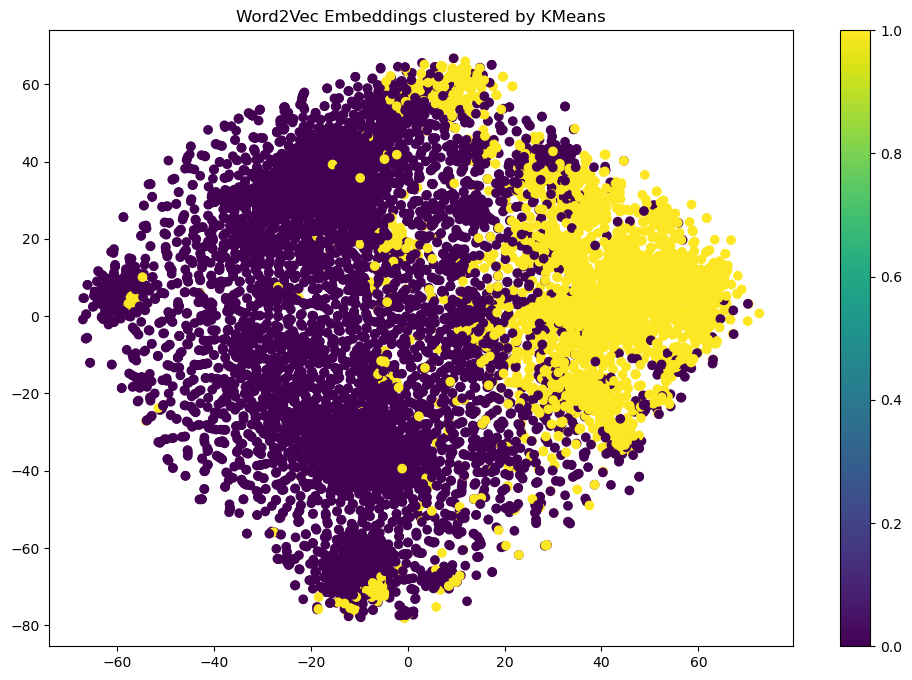

In [7]:
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np

# 加载Word2Vec模型
model = Word2Vec.load("/home/qiansongping/Experimental_Fish_3/4.BPE/bpe_results/word2vec_model_cbow.model")

# 获取所有词的词向量
word_vectors = model.wv.vectors
words = model.wv.index_to_key  # 获取单词列表

# 使用KMeans进行聚类
num_clusters = 2  # 设置聚类数量
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
word_labels = kmeans.fit_predict(word_vectors)

# 使用t-SNE进行降维
tsne = TSNE(n_components=2, random_state=42)
word_vectors_2d = tsne.fit_transform(word_vectors)

# 绘制词向量的2D图像
plt.figure(figsize=(12, 8))
scatter = plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], c=word_labels, cmap='viridis', marker='o')

# 添加颜色图例
plt.colorbar(scatter)


plt.title('Word2Vec Embeddings clustered by KMeans')
plt.show()

/home/qiansongping/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


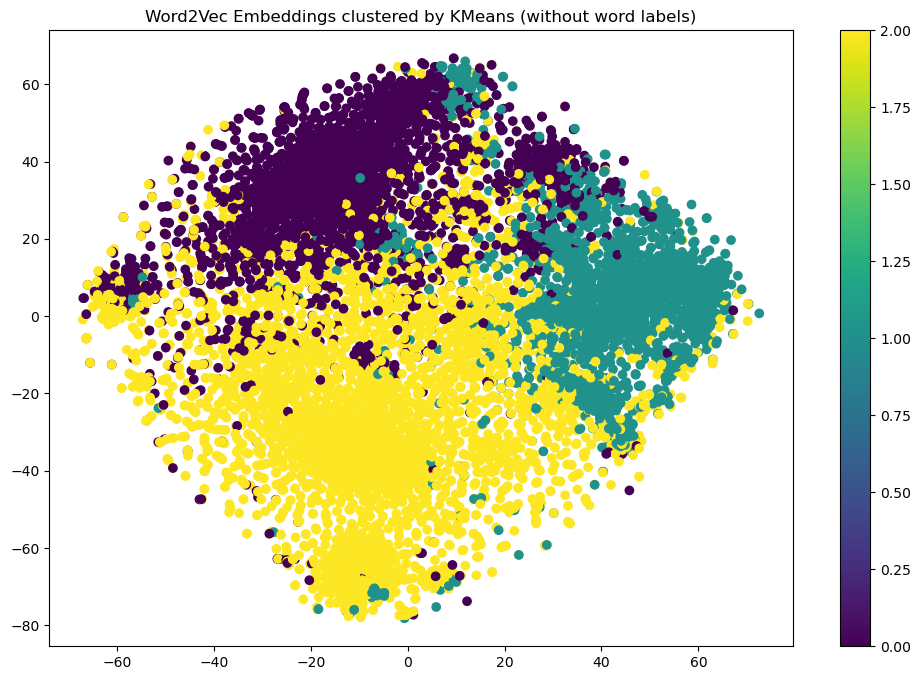

In [1]:
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# 加载Word2Vec模型
model = Word2Vec.load("/home/qiansongping/Experimental_Fish_3/4.BPE/bpe_results/word2vec_model_cbow.model")

# 获取所有词的词向量
word_vectors = model.wv.vectors
words = model.wv.index_to_key  # 获取单词列表

# 使用KMeans进行聚类
num_clusters = 3  # 设置聚类数量
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
word_labels = kmeans.fit_predict(word_vectors)

# 使用t-SNE进行降维
tsne = TSNE(n_components=2, random_state=42)
word_vectors_2d = tsne.fit_transform(word_vectors)

# 绘制词向量的2D图像（不显示单词）
plt.figure(figsize=(12, 8))
scatter = plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], c=word_labels, cmap='viridis', marker='o')

# 添加颜色图例
plt.colorbar(scatter)

plt.title('Word2Vec Embeddings clustered by KMeans (without word labels)')
plt.show()


In [5]:
from Bio import SeqIO
import os
from tqdm import tqdm

sea = [215358, 129043, 441366, 181472, 173247, 41447, 2871759, 109905, 80966, 80972, 144197, 7950, 184585, 8049, 80720, 1042646, 586833, 8245, 375764, 241271, 56723, 1203425, 508554, 433405, 229290, 184440, 56716, 8103, 293821, 300413, 310571, 8218, 160734, 52239, 2059687, 72105, 40690, 8267, 195615, 8255, 8262, 52904, 28829, 90069, 27771, 13676, 8236, 8240, 13677, 8175, 161448, 161450, 161453, 109280, 109293, 270530, 161584, 693459, 161469, 161592, 161455, 433684]
fresh = [64144, 158456, 1250792, 390379, 8090, 30732, 147949, 119488, 7994, 42526, 42514, 63155, 8154, 8153, 106582, 32507, 303518, 43689, 299321, 7959, 7955, 1142201, 84645, 369639, 90988, 1606681, 992332, 1582913, 52670, 77115, 33528, 208333, 37003, 105023, 8081, 48698, 48701, 188132, 8083, 8084, 32473, 8010, 409849, 8005, 137520, 42636, 1676925, 113540, 210632, 54343, 417921, 8167, 8168, 283035, 941984, 13013, 337641, 7998, 66913, 310915, 175797, 1234273, 175792, 2290929, 205130, 43700]

path = '/home/qiansongping/Experimental_Fish_3/2.Orthofinder/Data_og'
for filename in tqdm(os.listdir(path)):
    tax_id = filename.split('_')[0]
    if int(tax_id) in sea:
        file = os.path.join(path, filename)
        with open('/home/qiansongping/Experimental_Fish_3/2.Orthofinder/sea.faa', 'a') as f:
            for record in SeqIO.parse(file, 'fasta'):
                SeqIO.write(record, f, "fasta")
    if int(tax_id) in fresh:
        file = os.path.join(path, filename)
        with open('/home/qiansongping/Experimental_Fish_3/2.Orthofinder/fresh.faa', 'a') as f:
            for record in SeqIO.parse(file, 'fasta'):
                SeqIO.write(record, f, "fasta")

100%|██████████| 153/153 [00:43<00:00,  3.55it/s]


In [1]:
from Bio import SeqIO
seapath = '/home/qiansongping/Experimental_Fish_3/2.Orthofinder/sea_fresh_cldn.fasta'
# freshpath = '/home/qiansongping/Experimental_Fish_3/2.Orthofinder/fresh_cldnf.faa'
with open(seapath, 'w') as f:
    for record in SeqIO.parse('/home/qiansongping/Experimental_Fish_3/2.Orthofinder/sea.faa', 'fasta'):
        name = record.description.split()[1]
        # print(name)
        if name.startswith('cldn'):
            reco = SeqIO.SeqRecord(record.seq, id=f"{record.id}", description=f"{record.description} class=seawater")
            SeqIO.write(reco, f, "fasta")
            # print(record)
            # print(record)
print('----------------------------------------------------------------------------------')
with open(seapath, 'a') as f:
    for record in SeqIO.parse('/home/qiansongping/Experimental_Fish_3/2.Orthofinder/fresh.faa', 'fasta'):
        name = record.description.split()[1]
        # print(name)
        if name.startswith('cldn'):
            reco = SeqIO.SeqRecord(record.seq, id=f"{record.id}", description=f"{record.description} class=freshwater")
            SeqIO.write(reco, f, "fasta")
            # print(record)
            # print(record)

----------------------------------------------------------------------------------


### 论文数据整理

In [1]:
import os
from Bio import SeqIO
from tqdm import tqdm

path='/home/qiansongping/Experimental_Fish_3/1.Datasets/fish_faa_gff_sort'
path1 = '/home/qiansongping/Experimental_Fish_3/1.Datasets/dataset'
path2 = '/home/qiansongping/Experimental_Fish_3/2.Orthofinder/Data_og'
sort_count = {}
dup_count = {}
og_count = {}
for filename in tqdm(os.listdir(path)):
    taxid = filename.split('_')[0]
    if filename.endswith('.faa'):
        file_path = os.path.join(path, filename)
        records = list(SeqIO.parse(file_path, "fasta"))
    sort_count[taxid] = len(records)

100%|██████████| 153/153 [01:16<00:00,  2.00it/s]


In [2]:
for filename in tqdm(os.listdir(path1)):
    taxid = filename.split('_')[0]
    if filename.endswith('.faa'):
        file_path = os.path.join(path1, filename)
        records = list(SeqIO.parse(file_path, "fasta"))
    dup_count[taxid] = len(records)

100%|██████████| 153/153 [00:39<00:00,  3.89it/s]


In [4]:
for filename in tqdm(os.listdir(path2)):
    taxid = filename.split('_')[0]
    if filename.endswith('.faa'):
        file_path = os.path.join(path2, filename)
        records = list(SeqIO.parse(file_path, "fasta"))
    og_count[taxid] = len(records)

100%|██████████| 153/153 [00:36<00:00,  4.23it/s]


In [7]:
loc_count = {}
symbol_count = {}
for filename in tqdm(os.listdir(path2)):
    taxid = filename.split('_')[0]
    if filename.endswith('.faa'):
        file_path = os.path.join(path2, filename)
        for record in SeqIO.parse(file_path, "fasta"):
            symbol = record.description.split()[1]
            if symbol.startswith("LOC"):
                loc_count[taxid] = loc_count.get(taxid, 0) + 1
            else:
                symbol_count[taxid] = symbol_count.get(taxid, 0) + 1

100%|██████████| 153/153 [00:16<00:00,  9.10it/s]


In [8]:
with open('/home/qiansongping/Experimental_Fish_3/2.Orthofinder/附表3.csv', 'w') as f:
    f.write('specie,sorting,deup,OG,symbol,LOC\n')
    for taxid,count in sort_count.items():
        # print(type(tax),tax)
        f.write(f'{taxid},{count},{dup_count[taxid]},{og_count[taxid]},{symbol_count[taxid]},{loc_count[taxid]}\n')

In [9]:
for tax,count in sort_count.items():
    print(tax,count,dup_count[tax],{og_count[taxid]},symbol_count[tax],loc_count[tax])

1042646 37401 19746 12030 7716
105023 46741 19055 13286 5769
106582 46173 21448 14535 6913
109280 41964 18944 13740 5204
109293 42893 18260 12799 5461
109905 33912 19649 13884 5765
113540 47753 20940 13619 7321
1142201 36526 20648 16972 3676
118141 40137 22593 12147 10446
119488 58502 19424 13910 5514
1203425 39434 19453 13265 6188
1234273 55521 20315 15336 4979
1250792 45791 20189 13766 6423
129043 40291 20310 13395 6915
13013 40777 20578 15484 5094
13489 54417 20410 14194 6216
134920 40919 19370 13717 5653
13676 30506 20629 13776 6853
13677 31217 20179 13784 6395
137520 38428 18428 12871 5557
144197 31601 19909 14382 5527
147949 48260 20793 13508 7285
150288 33893 19577 13094 6483
1582913 44123 20225 16238 3987
158456 52064 19838 13952 5886
159077 48545 19492 12491 7001
1606681 48681 21816 16399 5417
160734 36199 21593 12825 8768
161448 44735 18785 12698 6087
161450 45890 18633 13031 5602
161453 48560 18310 13265 5045
161455 50228 21113 11742 9371
161469 53264 17915 13104 4811
161584

In [1]:
from Bio import SeqIO
from tqdm import tqdm
import os

sea = [215358, 129043, 441366, 181472, 173247, 41447, 30732, 2871759, 109905, 80966, 80972, 144197, 7950, 184585, 8049, 80720, 1042646, 586833, 8245, 375764, 241271, 56723, 1203425, 508554, 433405, 229290, 184440, 56716, 8103, 293821, 300413, 310571, 8218, 160734, 52239, 2059687, 72105, 40690, 8267, 195615, 8255, 8262, 52904, 28829, 90069, 27771, 13676, 8236, 8240, 13677, 8175, 161448, 161450, 161453, 109280, 109293, 270530, 161584, 693459, 161469, 161592, 161455, 433684]
fresh = [64144, 158456, 1250792, 390379, 8090, 147949, 119488, 7994, 42526, 42514, 63155, 8154, 8153, 106582, 32507, 303518, 43689, 299321, 7959, 7955, 1142201, 84645, 369639, 90988, 1606681, 992332, 1582913, 52670, 77115, 33528, 208333, 37003, 105023, 8081, 48698, 48701, 188132, 8083, 8084, 32473, 8010, 409849, 8005, 137520, 42636, 1676925, 113540, 210632, 54343, 417921, 8167, 8168, 283035, 941984, 13013, 337641, 7998, 66913, 310915, 175797, 1234273, 175792, 2290929, 205130, 43700]
path='/home/qiansongping/Experimental_Fish_3/1.Datasets/dataset'

In [2]:
or_count = {} 
for file in tqdm(os.listdir(path)):
    protein_path = os.path.join(path, file)
    taxid = file.split('_')[0]
    if int(taxid) in sea or int(taxid) in fresh: 
        for record in SeqIO.parse(protein_path, "fasta"):
            symbol = record.description.split()[1]
            if symbol.startswith("cldnf"):
                or_count[taxid] = or_count.get(taxid, 0) + 1 
            else:
                or_count[taxid] = or_count.get(taxid, 0)       

100%|██████████| 153/153 [00:18<00:00,  8.34it/s]


In [3]:
taar_count = {} 
for file in tqdm(os.listdir(path)):
    protein_path = os.path.join(path, file)
    taxid = file.split('_')[0]
    if int(taxid) in sea or int(taxid) in fresh: 
        for record in SeqIO.parse(protein_path, "fasta"):
            symbol = record.description.split()[1]
            if symbol.startswith("cldn"):
                taar_count[taxid] = taar_count.get(taxid, 0) + 1 
            else:
                taar_count[taxid] = taar_count.get(taxid, 0)       

100%|██████████| 153/153 [00:16<00:00,  9.47it/s]


In [4]:
import json
with open('/home/qiansongping/Experimental_Fish_3/2.Orthofinder/taxid_name.json', 'r') as f:
    taxid_name = json.load(f)

In [5]:
with open('/home/qiansongping/Experimental_Fish_3/2.Orthofinder/cldn_count.txt','w') as f:
    f.write('species,cldnf,cldn,class\n')
    for k,v in or_count.items():
        if int(k) in fresh:
            f.write(f"{taxid_name[k]},{v},{taar_count[k]},fresh\n")
        if int(k) in sea:
            f.write(f"{taxid_name[k]},{v},{taar_count[k]},sea\n")

In [6]:
for tax,count in or_count.items():
    if int(tax) in fresh:
        print(taxid_name[tax],count,'fresh')
    
print('----------------------------------')
for tax,count in or_count.items():
    if int(tax) in sea:
        print(taxid_name[tax],count,'sea')


Nothobranchius furzeri 0 fresh
Maylandia zebra 1 fresh
Scleropages formosus 1 fresh
Danio aesculapii 0 fresh
Siniperca chuatsi 0 fresh
Tachysurus fulvidraco 0 fresh
Melanotaenia boesemani 0 fresh
Clarias gariepinus 0 fresh
Hypomesus transpacificus 0 fresh
Micropterus dolomieu 0 fresh
Triplophysa dalaica 0 fresh
Betta splendens 1 fresh
Puntigrus tetrazona 0 fresh
Paramormyrops kingsleyae 1 fresh
Tachysurus vachellii 0 fresh
Silurus meridionalis 0 fresh
Poeciliopsis prolifica 1 fresh
Mastacembelus armatus 1 fresh
Girardinichthys multiradiatus 1 fresh
Parambassis ranga 1 fresh
Trichomycterus rosablanca 1 fresh
Sander lucioperca 1 fresh
Denticeps clupeoides 1 fresh
Pundamilia nyererei 1 fresh
Oryzias melastigma 0 fresh
Pangasianodon hypophthalmus 1 fresh
Xiphophorus couchianus 1 fresh
Neolamprologus brichardi 1 fresh
Gambusia affinis 0 fresh
Hemibagrus wyckioides 1 fresh
Onychostoma macrolepis 1 fresh
Kryptolebias marmoratus 0 fresh
Thalassophryne amazonica 1 fresh
Periophthalmus magnuspin

In [5]:
for tax,count in taar_count.items():
    if int(tax) in fresh:
        print(tax,count)
    
print('----------------------------------')
for tax,count in taar_count.items():
    if int(tax) in sea:
        print(tax,count)

105023 0
106582 0
113540 0
1142201 8
119488 0
1234273 1
1250792 0
13013 1
137520 0
147949 0
1582913 3
158456 0
1606681 5
1676925 0
175792 1
175797 2
188132 0
205130 0
208333 0
210632 0
2290929 2
283035 0
299321 0
303518 0
30732 0
310915 2
32473 0
32507 0
33528 0
337641 2
369639 6
37003 0
390379 0
409849 0
417921 0
42514 2
42526 2
42636 0
43689 0
43700 0
48698 0
48701 0
52670 0
54343 0
63155 0
64144 0
66913 2
77115 0
7955 57
7959 4
7994 2
7998 2
8005 2
8010 0
8081 0
8083 0
8084 0
8090 0
8153 0
8154 0
8167 0
8168 0
84645 5
90988 3
941984 0
992332 3
----------------------------------
1042646 0
109280 0
109293 0
109905 0
1203425 0
129043 0
13676 0
13677 0
144197 0
160734 0
161448 0
161450 0
161453 0
161455 0
161469 0
161584 0
161592 0
173247 0
181472 0
184440 0
184585 0
195615 0
2059687 0
215358 0
229290 0
241271 0
270530 0
27771 0
2871759 0
28829 0
293821 0
300413 0
310571 0
375764 0
40690 0
41447 0
433405 0
433684 0
441366 0
508554 0
52239 0
52904 0
56716 0
56723 0
586833 0
693459 0
7210